# Practice

In [18]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = './'
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

In [19]:
# train.json과 validation.json 파일은 이미지에 담겨 있는 사람들의 pose keypoint 정보들을 가지고 있다.
# 따라서 Pose Estimation을 위한 label로 삼을 수 있다.
# 아래는 annotation 정보 1개 출력
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


In [20]:
# joints_vis 는 사용할 수 있는 keypoint 인지 나타낸다.
# MPII 의 경우 1 (visible) / 0(non) 으로만 나누어져 있다. 
# coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label 화 되어 있다.

# joints 순서는 아래와 같은 순서로 배치
'''
0 - 오른쪽 발목
1 - 오른쪽 무릎
2 - 오른쪽 엉덩이
3 - 왼쪽 엉덩이
4 - 왼쪽 무릎
5 - 왼쪽 발목
6 - 골반
7 - 가슴(흉부)
8 - 목
9 - 머리 위
10 - 오른쪽 손목
11 - 오른쪽 팔꿈치
12 - 오른쪽 어깨
13 - 왼쪽 어깨
14 - 왼쪽 팔꿈치
15 - 왼쪽 손목
'''

# scale과 center는 사람 몸의 크기와 중심점

'\n0 - 오른쪽 발목\n1 - 오른쪽 무릎\n2 - 오른쪽 엉덩이\n3 - 왼쪽 엉덩이\n4 - 왼쪽 무릎\n5 - 왼쪽 발목\n6 - 골반\n7 - 가슴(흉부)\n8 - 목\n9 - 머리 위\n10 - 오른쪽 손목\n11 - 오른쪽 팔꿈치\n12 - 오른쪽 어깨\n13 - 왼쪽 어깨\n14 - 왼쪽 팔꿈치\n15 - 왼쪽 손목\n'

In [21]:
# json annotation 을 파싱하는 함수
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [22]:
# parse_one_annotation()함수 테스트
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


In [23]:
# TFRecord 형태로 표현
# 내부적으로 protocol buffer 라는 것을 이용
# protocol buffer 는 크로스 플랫폼에서 사용할 수 있는 직렬화 데이터 라이브러리라고 생각하면 된다.
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [24]:
# 하나의 TFRecord가 아닌 다수의 TFRecord를 만들기

# 얼마나 많은 TFRecord를 만들지 결정할 함수
# 전체 데이터 l을 n그룹으로 나눈다. 결과적으로 n개의 TFRecord 파일을 만든다.
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [25]:
# Test
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

# 15묶음씩 64개로 나뉘는 것을 확인할 수 있다.

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [26]:
# RAY 활용
# Ray는 병렬 처리를 위한 라이브러리

@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [27]:
# TFRecord 파일로 만들어주는 함수
# ray를 사용하기 때문에 함수를 호출하는 문법이 약간 다르다.
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [11]:
# 앞서 작성한 함수를 사용해 데이터를 TFRecord로 만든다.
# train 데이터는 64개로, val 데이터는 8개의 파일로 만든다.
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-03-18 10:17:03,129	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.66gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=2030) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=2030) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=2031) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=2031) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=2032) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=2032) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=2031) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=2031) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

(build_single_tfrecord pid=2030) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0054_of_0064.tfrecords
(build_single_tfrecord pid=2030) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=2031) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=2031) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=2032) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=2032) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=2030) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=2030) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/t

In [28]:
# 함수나 클래스에 @ray.remote 데코레이터를 붙이고 some_function.remote()형식으로 함수를 만든다.
# 클래스의 경우에는 메서드를 호출할 때 remote()를 이용한다.
# 함수나 메서드는 이 시점에 실행되는 것이 아니라 생성만 된다.
# ray.get()을 통해 실행이 되는 구조이다.

In [29]:
# TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [30]:
# image 와 label 을 이용해서 적절한 학습 형태로 변환한다.
# 이미지를 그대로 사용하지 않고 적당히 정사각형으로 crop한다.
# 균일하게 학습하기 위해 body width 를 적절히 정하는 것도 중요하다.
# 임의로 조정한 crop box 가 이미지 바깥으로 나가지 않는지 예외 처리를 잘 해주어야 한다.
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

In [31]:
# (x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경시키는 함수 (2차원 가우시안 분포)
# 
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [32]:
# 함수들을 개별 함수로도 만들 수 있지만 객체 형태로 조합하는 함수
# 객체 형태로 만들면 선언부는 복잡해 보여도 장점이 훨씬 많다.
# 함수에서 객체의 메서드로 수정할 때는 self를 추가해야 한다.
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

# Hourglass 모델 생성

In [15]:
#  residual block
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [16]:
# HourglassModule
# 재귀 함수를 이용
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [17]:
# Intermediate supervision 적용을 위한 linear layer
# 여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워, 저자들은 Intermediate supervision을 적용했다.
# 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer틑 사용한다.
# 이 히트맵과 ground truth의 차이를 intermediate loss (auxilary loss) 로 계산한다.
# 이로써 stacked hourglass module은 보다 정교한 결과를 도출해낸다.
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [18]:
# StackedHourglassNetwork 생성
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [30]:
StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap).summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_6 (ReLU)                  (None, 128, 128, 64) 0           batch_normalization_6[0][0]      
__________________________________________________________________________________

__________________________________________________________________________________________________
up_sampling2d_8 (UpSampling2D)  (None, 8, 8, 256)    0           add_54[0][0]                     
__________________________________________________________________________________________________
add_51 (Add)                    (None, 8, 8, 256)    0           add_50[0][0]                     
                                                                 conv2d_161[0][0]                 
__________________________________________________________________________________________________
re_lu_146 (ReLU)                (None, 16, 16, 128)  0           batch_normalization_146[0][0]    
__________________________________________________________________________________________________
tf.__operators__.add_8 (TFOpLam (None, 8, 8, 256)    0           up_sampling2d_8[0][0]            
                                                                 add_51[0][0]                     
__________

In [20]:
# 학습을 할 수 있는 GPU가 여러 개이고 데이터를 병렬로 학습시키는 방법
# tf.distribute.MirroredStrategy : 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법
# GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합, 그런 후 모델의 가중치 업데이트.
# 각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할은 strategy.reduce 함수가 담당
# 각 함수 하나의 객체로 생성
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [21]:
# 데이터셋을 만드는 함수
# TFRecord 파일이 여러개이므로 tf.data.Dataset.list_files를 통해 불러온다.
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [22]:
#  데이터셋과 모델, 훈련용 객체를 조립
#  with strategy.scope():부분이 반드시 필요하다.
# 데이터셋도 experimental_distribute_dataset를 통해 연결해 줘야 한다.
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

# 훈련 그래프 시각화

In [ ]:
import pandas as pd
!pip install openpyxl

In [13]:
# 엑셀 파일 경로
file_path = "StackedHourglassNetwork_training_data.xlsx"

# 각 시트를 데이터 프레임으로 불러오기
df_train = pd.read_excel(file_path, sheet_name="train")
df_validation = pd.read_excel(file_path, sheet_name="validation")

In [14]:
df_train.head()

,Epoch,Batch,Loss,Total_Loss
0,1,1,2.130562,2.130562
1,1,2,2.209572,2.170067
2,1,3,2.333928,2.224688
3,1,4,2.298592,2.243164
4,1,5,2.345860,2.263703


In [15]:
train_last_total_loss_per_epoch = df_train.groupby("Epoch")["Total_Loss"].last().tolist()
print(train_last_total_loss_per_epoch)

[1.54673707, 1.36607063, 1.27828228, 1.22301698, 1.18356013]


In [16]:
val_last_total_loss_per_epoch = df_validation.groupby("Epoch")["Loss"].mean().tolist()
print(val_last_total_loss_per_epoch)

[1.43289166, 1.306093953783784, 1.273289129227027, 1.212238144054054, 1.1768244690918919]


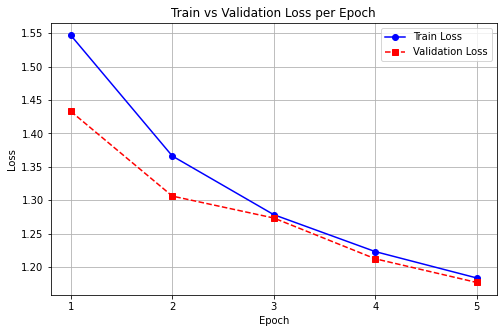

In [17]:
import matplotlib.pyplot as plt

# 에포크 리스트 (x축)
epochs = list(range(1, len(train_last_total_loss_per_epoch) + 1))

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_last_total_loss_per_epoch, marker='o', linestyle='-', label='Train Loss', color='blue')
plt.plot(epochs, val_last_total_loss_per_epoch, marker='s', linestyle='--', label='Validation Loss', color='red')

# 그래프 제목 및 라벨
plt.title("Train vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)  # X축 눈금 에포크에 맞추기
plt.legend()  # 범례 추가
plt.grid(True)  # 격자 표시

# 그래프 출력
plt.show()

In [23]:
import os
print("MODEL_PATH:", MODEL_PATH)
print("Does the path exist?", os.path.exists(MODEL_PATH))

MODEL_PATH: ./
Does the path exist? True


In [29]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.13056231 epoch total loss 2.13056231
Trained batch 2 batch loss 2.20957208 epoch total loss 2.17006731
Trained batch 3 batch loss 2.33392835 epoch total loss 2.22468758
Trained batch 4 batch loss 2.29859161 epoch total loss 2.24316359
Trained batch 5 batch loss 2.34586 epoch total loss 2.26370287
Trained batch 6 batch loss 2.38549423 epoch total loss 2.28400135
Trained batch 7 batch loss 2.33372664 epoch total loss 2.29110503
Trained batch 8 batch loss 2.3252728 epoch total loss 2.29537606
Trained batch 9 batch loss 2.25175238 epoch total loss 2.29052901
Trained batch 10 batch loss 2.20771933 epoch total loss 2.28224802
Trained batch 11 batch loss 2.25419402 epoch total loss 2.27969766
Trained batch 12 batch loss 2.1771059 epoch total loss 2.27114844
Trained batch 13 ba

Trained batch 121 batch loss 1.70186734 epoch total loss 1.78405643
Trained batch 122 batch loss 1.69838095 epoch total loss 1.78335416
Trained batch 123 batch loss 1.66961598 epoch total loss 1.78242958
Trained batch 124 batch loss 1.58640432 epoch total loss 1.78084874
Trained batch 125 batch loss 1.64035463 epoch total loss 1.77972472
Trained batch 126 batch loss 1.67242694 epoch total loss 1.77887309
Trained batch 127 batch loss 1.64440727 epoch total loss 1.77781439
Trained batch 128 batch loss 1.65357077 epoch total loss 1.77684367
Trained batch 129 batch loss 1.61237335 epoch total loss 1.77556872
Trained batch 130 batch loss 1.55901921 epoch total loss 1.77390301
Trained batch 131 batch loss 1.51969361 epoch total loss 1.77196252
Trained batch 132 batch loss 1.55003905 epoch total loss 1.7702812
Trained batch 133 batch loss 1.65858793 epoch total loss 1.76944137
Trained batch 134 batch loss 1.67695546 epoch total loss 1.76875126
Trained batch 135 batch loss 1.64921415 epoch tot

Trained batch 242 batch loss 1.62316954 epoch total loss 1.71088612
Trained batch 243 batch loss 1.67416179 epoch total loss 1.71073508
Trained batch 244 batch loss 1.66288304 epoch total loss 1.71053886
Trained batch 245 batch loss 1.66672158 epoch total loss 1.71036
Trained batch 246 batch loss 1.64965153 epoch total loss 1.71011329
Trained batch 247 batch loss 1.67030871 epoch total loss 1.70995212
Trained batch 248 batch loss 1.65091431 epoch total loss 1.70971406
Trained batch 249 batch loss 1.65791559 epoch total loss 1.70950615
Trained batch 250 batch loss 1.64781642 epoch total loss 1.70925939
Trained batch 251 batch loss 1.62875557 epoch total loss 1.70893872
Trained batch 252 batch loss 1.63841724 epoch total loss 1.70865881
Trained batch 253 batch loss 1.61475122 epoch total loss 1.70828772
Trained batch 254 batch loss 1.61126637 epoch total loss 1.70790565
Trained batch 255 batch loss 1.64362788 epoch total loss 1.70765352
Trained batch 256 batch loss 1.63173699 epoch total

Trained batch 363 batch loss 1.59346 epoch total loss 1.68480551
Trained batch 364 batch loss 1.69408584 epoch total loss 1.68483102
Trained batch 365 batch loss 1.63553286 epoch total loss 1.68469608
Trained batch 366 batch loss 1.71811199 epoch total loss 1.68478739
Trained batch 367 batch loss 1.6525867 epoch total loss 1.68469965
Trained batch 368 batch loss 1.5935632 epoch total loss 1.68445206
Trained batch 369 batch loss 1.75007772 epoch total loss 1.68462992
Trained batch 370 batch loss 1.76048958 epoch total loss 1.68483496
Trained batch 371 batch loss 1.63992751 epoch total loss 1.68471396
Trained batch 372 batch loss 1.53912449 epoch total loss 1.6843226
Trained batch 373 batch loss 1.54132128 epoch total loss 1.68393922
Trained batch 374 batch loss 1.51143599 epoch total loss 1.68347788
Trained batch 375 batch loss 1.56529808 epoch total loss 1.68316281
Trained batch 376 batch loss 1.45785165 epoch total loss 1.68256342
Trained batch 377 batch loss 1.59916639 epoch total lo

Trained batch 484 batch loss 1.61353993 epoch total loss 1.65771699
Trained batch 485 batch loss 1.61035323 epoch total loss 1.65761936
Trained batch 486 batch loss 1.59626412 epoch total loss 1.65749311
Trained batch 487 batch loss 1.5602417 epoch total loss 1.65729332
Trained batch 488 batch loss 1.59765697 epoch total loss 1.65717113
Trained batch 489 batch loss 1.48787236 epoch total loss 1.65682495
Trained batch 490 batch loss 1.44391465 epoch total loss 1.65639043
Trained batch 491 batch loss 1.42728162 epoch total loss 1.65592384
Trained batch 492 batch loss 1.54441166 epoch total loss 1.65569723
Trained batch 493 batch loss 1.43916571 epoch total loss 1.65525794
Trained batch 494 batch loss 1.61576867 epoch total loss 1.65517807
Trained batch 495 batch loss 1.59716165 epoch total loss 1.65506089
Trained batch 496 batch loss 1.56386614 epoch total loss 1.65487695
Trained batch 497 batch loss 1.3491894 epoch total loss 1.65426183
Trained batch 498 batch loss 1.56576729 epoch tota

Trained batch 606 batch loss 1.43247235 epoch total loss 1.6358211
Trained batch 607 batch loss 1.4990623 epoch total loss 1.63559592
Trained batch 608 batch loss 1.57010221 epoch total loss 1.63548815
Trained batch 609 batch loss 1.55351043 epoch total loss 1.63535368
Trained batch 610 batch loss 1.59808791 epoch total loss 1.63529253
Trained batch 611 batch loss 1.43786204 epoch total loss 1.63496935
Trained batch 612 batch loss 1.51705146 epoch total loss 1.63477671
Trained batch 613 batch loss 1.53376222 epoch total loss 1.63461185
Trained batch 614 batch loss 1.42878962 epoch total loss 1.63427663
Trained batch 615 batch loss 1.55268717 epoch total loss 1.63414395
Trained batch 616 batch loss 1.53786445 epoch total loss 1.63398767
Trained batch 617 batch loss 1.5152781 epoch total loss 1.63379514
Trained batch 618 batch loss 1.55688429 epoch total loss 1.63367069
Trained batch 619 batch loss 1.52791786 epoch total loss 1.63349986
Trained batch 620 batch loss 1.59349465 epoch total

Trained batch 728 batch loss 1.47635341 epoch total loss 1.61223
Trained batch 729 batch loss 1.39298868 epoch total loss 1.61192906
Trained batch 730 batch loss 1.4426198 epoch total loss 1.6116972
Trained batch 731 batch loss 1.53461552 epoch total loss 1.61159182
Trained batch 732 batch loss 1.41040242 epoch total loss 1.61131692
Trained batch 733 batch loss 1.55626857 epoch total loss 1.61124182
Trained batch 734 batch loss 1.54638994 epoch total loss 1.61115348
Trained batch 735 batch loss 1.59036839 epoch total loss 1.61112523
Trained batch 736 batch loss 1.73021197 epoch total loss 1.611287
Trained batch 737 batch loss 1.72079873 epoch total loss 1.61143565
Trained batch 738 batch loss 1.67884326 epoch total loss 1.61152697
Trained batch 739 batch loss 1.52935886 epoch total loss 1.61141586
Trained batch 740 batch loss 1.36555529 epoch total loss 1.61108363
Trained batch 741 batch loss 1.27434874 epoch total loss 1.6106292
Trained batch 742 batch loss 1.45629883 epoch total loss

Trained batch 850 batch loss 1.60095239 epoch total loss 1.59761345
Trained batch 851 batch loss 1.57730222 epoch total loss 1.59758949
Trained batch 852 batch loss 1.61809993 epoch total loss 1.59761357
Trained batch 853 batch loss 1.52801335 epoch total loss 1.59753191
Trained batch 854 batch loss 1.57482529 epoch total loss 1.59750533
Trained batch 855 batch loss 1.46550107 epoch total loss 1.59735084
Trained batch 856 batch loss 1.64344621 epoch total loss 1.59740472
Trained batch 857 batch loss 1.5960784 epoch total loss 1.59740317
Trained batch 858 batch loss 1.54651344 epoch total loss 1.5973438
Trained batch 859 batch loss 1.60285473 epoch total loss 1.59735024
Trained batch 860 batch loss 1.55751419 epoch total loss 1.59730399
Trained batch 861 batch loss 1.43379784 epoch total loss 1.59711409
Trained batch 862 batch loss 1.57313538 epoch total loss 1.59708631
Trained batch 863 batch loss 1.58966804 epoch total loss 1.59707773
Trained batch 864 batch loss 1.61983669 epoch tota

Trained batch 972 batch loss 1.52123642 epoch total loss 1.58235
Trained batch 973 batch loss 1.50432277 epoch total loss 1.58226979
Trained batch 974 batch loss 1.56962514 epoch total loss 1.58225667
Trained batch 975 batch loss 1.52716672 epoch total loss 1.58220029
Trained batch 976 batch loss 1.54146147 epoch total loss 1.58215857
Trained batch 977 batch loss 1.51663065 epoch total loss 1.58209145
Trained batch 978 batch loss 1.55468845 epoch total loss 1.58206344
Trained batch 979 batch loss 1.37475181 epoch total loss 1.58185172
Trained batch 980 batch loss 1.44026744 epoch total loss 1.58170724
Trained batch 981 batch loss 1.44016218 epoch total loss 1.581563
Trained batch 982 batch loss 1.43658638 epoch total loss 1.58141541
Trained batch 983 batch loss 1.43763137 epoch total loss 1.58126915
Trained batch 984 batch loss 1.45204639 epoch total loss 1.58113778
Trained batch 985 batch loss 1.48441458 epoch total loss 1.58103955
Trained batch 986 batch loss 1.45140088 epoch total l

Trained batch 1092 batch loss 1.53104377 epoch total loss 1.57065642
Trained batch 1093 batch loss 1.39531267 epoch total loss 1.57049596
Trained batch 1094 batch loss 1.40072823 epoch total loss 1.57034087
Trained batch 1095 batch loss 1.42536974 epoch total loss 1.57020843
Trained batch 1096 batch loss 1.46309912 epoch total loss 1.5701108
Trained batch 1097 batch loss 1.4453603 epoch total loss 1.56999707
Trained batch 1098 batch loss 1.42554593 epoch total loss 1.56986547
Trained batch 1099 batch loss 1.51542068 epoch total loss 1.56981587
Trained batch 1100 batch loss 1.37742686 epoch total loss 1.56964099
Trained batch 1101 batch loss 1.47671473 epoch total loss 1.56955659
Trained batch 1102 batch loss 1.49864769 epoch total loss 1.56949222
Trained batch 1103 batch loss 1.46601129 epoch total loss 1.56939852
Trained batch 1104 batch loss 1.55830908 epoch total loss 1.56938851
Trained batch 1105 batch loss 1.54100239 epoch total loss 1.56936276
Trained batch 1106 batch loss 1.2734

Trained batch 1212 batch loss 1.4447757 epoch total loss 1.56006074
Trained batch 1213 batch loss 1.53712928 epoch total loss 1.56004179
Trained batch 1214 batch loss 1.635463 epoch total loss 1.56010389
Trained batch 1215 batch loss 1.25254083 epoch total loss 1.55985081
Trained batch 1216 batch loss 1.29328096 epoch total loss 1.55963171
Trained batch 1217 batch loss 1.23228824 epoch total loss 1.55936265
Trained batch 1218 batch loss 1.47042036 epoch total loss 1.55928969
Trained batch 1219 batch loss 1.63970113 epoch total loss 1.55935562
Trained batch 1220 batch loss 1.71738613 epoch total loss 1.5594852
Trained batch 1221 batch loss 1.49398422 epoch total loss 1.55943155
Trained batch 1222 batch loss 1.29564619 epoch total loss 1.55921566
Trained batch 1223 batch loss 1.54948843 epoch total loss 1.55920768
Trained batch 1224 batch loss 1.46614814 epoch total loss 1.55913174
Trained batch 1225 batch loss 1.5470407 epoch total loss 1.55912185
Trained batch 1226 batch loss 1.4893184

Trained batch 1332 batch loss 1.33331037 epoch total loss 1.55084968
Trained batch 1333 batch loss 1.48448765 epoch total loss 1.55079973
Trained batch 1334 batch loss 1.41766024 epoch total loss 1.5507
Trained batch 1335 batch loss 1.47085965 epoch total loss 1.55064023
Trained batch 1336 batch loss 1.52677131 epoch total loss 1.55062246
Trained batch 1337 batch loss 1.60865426 epoch total loss 1.55066586
Trained batch 1338 batch loss 1.59285355 epoch total loss 1.55069733
Trained batch 1339 batch loss 1.53020465 epoch total loss 1.55068207
Trained batch 1340 batch loss 1.59363949 epoch total loss 1.55071425
Trained batch 1341 batch loss 1.54178619 epoch total loss 1.55070746
Trained batch 1342 batch loss 1.49614358 epoch total loss 1.55066681
Trained batch 1343 batch loss 1.4937284 epoch total loss 1.55062437
Trained batch 1344 batch loss 1.54876077 epoch total loss 1.55062306
Trained batch 1345 batch loss 1.47132182 epoch total loss 1.55056417
Trained batch 1346 batch loss 1.4691816

Validated batch 105 batch loss 1.48264241
Validated batch 106 batch loss 1.45882702
Validated batch 107 batch loss 1.46544552
Validated batch 108 batch loss 1.41982841
Validated batch 109 batch loss 1.43062079
Validated batch 110 batch loss 1.34544253
Validated batch 111 batch loss 1.36589074
Validated batch 112 batch loss 1.41971183
Validated batch 113 batch loss 1.34148884
Validated batch 114 batch loss 1.42609751
Validated batch 115 batch loss 1.42824018
Validated batch 116 batch loss 1.54454029
Validated batch 117 batch loss 1.51043165
Validated batch 118 batch loss 1.35597932
Validated batch 119 batch loss 1.30314934
Validated batch 120 batch loss 1.42250514
Validated batch 121 batch loss 1.39813185
Validated batch 122 batch loss 1.39807022
Validated batch 123 batch loss 1.38474178
Validated batch 124 batch loss 1.34351623
Validated batch 125 batch loss 1.50426066
Validated batch 126 batch loss 1.3597883
Validated batch 127 batch loss 1.37080729
Validated batch 128 batch loss 1.37

Trained batch 71 batch loss 1.37291956 epoch total loss 1.40103531
Trained batch 72 batch loss 1.39848554 epoch total loss 1.4009999
Trained batch 73 batch loss 1.35650396 epoch total loss 1.40039039
Trained batch 74 batch loss 1.45224428 epoch total loss 1.40109122
Trained batch 75 batch loss 1.30198395 epoch total loss 1.39976978
Trained batch 76 batch loss 1.46676767 epoch total loss 1.40065134
Trained batch 77 batch loss 1.40533376 epoch total loss 1.40071213
Trained batch 78 batch loss 1.51506591 epoch total loss 1.40217829
Trained batch 79 batch loss 1.59849131 epoch total loss 1.40466321
Trained batch 80 batch loss 1.6277287 epoch total loss 1.40745151
Trained batch 81 batch loss 1.44442511 epoch total loss 1.40790808
Trained batch 82 batch loss 1.356269 epoch total loss 1.4072783
Trained batch 83 batch loss 1.35204911 epoch total loss 1.40661287
Trained batch 84 batch loss 1.55499768 epoch total loss 1.40837944
Trained batch 85 batch loss 1.65365744 epoch total loss 1.41126502


Trained batch 193 batch loss 1.52858508 epoch total loss 1.41137099
Trained batch 194 batch loss 1.54720819 epoch total loss 1.41207111
Trained batch 195 batch loss 1.59892285 epoch total loss 1.41302943
Trained batch 196 batch loss 1.47494936 epoch total loss 1.41334534
Trained batch 197 batch loss 1.48299766 epoch total loss 1.41369891
Trained batch 198 batch loss 1.41293812 epoch total loss 1.4136951
Trained batch 199 batch loss 1.43857718 epoch total loss 1.41382
Trained batch 200 batch loss 1.51545691 epoch total loss 1.4143281
Trained batch 201 batch loss 1.45625 epoch total loss 1.41453671
Trained batch 202 batch loss 1.4696269 epoch total loss 1.41480947
Trained batch 203 batch loss 1.35051501 epoch total loss 1.41449273
Trained batch 204 batch loss 1.29788899 epoch total loss 1.41392112
Trained batch 205 batch loss 1.40229106 epoch total loss 1.41386437
Trained batch 206 batch loss 1.35696101 epoch total loss 1.41358817
Trained batch 207 batch loss 1.41984916 epoch total loss 

Trained batch 314 batch loss 1.41726184 epoch total loss 1.40930724
Trained batch 315 batch loss 1.46311307 epoch total loss 1.40947807
Trained batch 316 batch loss 1.3980422 epoch total loss 1.40944183
Trained batch 317 batch loss 1.34465635 epoch total loss 1.4092375
Trained batch 318 batch loss 1.35784066 epoch total loss 1.40907598
Trained batch 319 batch loss 1.35040629 epoch total loss 1.40889204
Trained batch 320 batch loss 1.40868711 epoch total loss 1.40889144
Trained batch 321 batch loss 1.40990567 epoch total loss 1.40889454
Trained batch 322 batch loss 1.41707933 epoch total loss 1.40892
Trained batch 323 batch loss 1.38200617 epoch total loss 1.40883672
Trained batch 324 batch loss 1.44884586 epoch total loss 1.40896022
Trained batch 325 batch loss 1.55442238 epoch total loss 1.40940773
Trained batch 326 batch loss 1.53186643 epoch total loss 1.40978336
Trained batch 327 batch loss 1.4136703 epoch total loss 1.40979528
Trained batch 328 batch loss 1.33997774 epoch total lo

Trained batch 436 batch loss 1.36592126 epoch total loss 1.4066143
Trained batch 437 batch loss 1.35302758 epoch total loss 1.40649164
Trained batch 438 batch loss 1.36270404 epoch total loss 1.40639174
Trained batch 439 batch loss 1.34336925 epoch total loss 1.40624821
Trained batch 440 batch loss 1.39935732 epoch total loss 1.40623248
Trained batch 441 batch loss 1.39312744 epoch total loss 1.40620279
Trained batch 442 batch loss 1.38921857 epoch total loss 1.40616441
Trained batch 443 batch loss 1.43052077 epoch total loss 1.40621936
Trained batch 444 batch loss 1.43281841 epoch total loss 1.40627933
Trained batch 445 batch loss 1.49562466 epoch total loss 1.40648
Trained batch 446 batch loss 1.43408644 epoch total loss 1.40654194
Trained batch 447 batch loss 1.54779696 epoch total loss 1.40685785
Trained batch 448 batch loss 1.43276453 epoch total loss 1.40691566
Trained batch 449 batch loss 1.41307509 epoch total loss 1.40692937
Trained batch 450 batch loss 1.30601799 epoch total 

Trained batch 557 batch loss 1.47721446 epoch total loss 1.40394485
Trained batch 558 batch loss 1.44696915 epoch total loss 1.40402186
Trained batch 559 batch loss 1.46996498 epoch total loss 1.40413988
Trained batch 560 batch loss 1.53641236 epoch total loss 1.40437615
Trained batch 561 batch loss 1.50913227 epoch total loss 1.40456283
Trained batch 562 batch loss 1.40971899 epoch total loss 1.40457213
Trained batch 563 batch loss 1.36124372 epoch total loss 1.40449512
Trained batch 564 batch loss 1.2970463 epoch total loss 1.40430462
Trained batch 565 batch loss 1.33885717 epoch total loss 1.40418887
Trained batch 566 batch loss 1.37017965 epoch total loss 1.40412879
Trained batch 567 batch loss 1.41552663 epoch total loss 1.40414882
Trained batch 568 batch loss 1.33783054 epoch total loss 1.40403211
Trained batch 569 batch loss 1.22897851 epoch total loss 1.40372455
Trained batch 570 batch loss 1.30057693 epoch total loss 1.40354359
Trained batch 571 batch loss 1.2849474 epoch tota

Trained batch 678 batch loss 1.20007169 epoch total loss 1.3951124
Trained batch 679 batch loss 1.45076394 epoch total loss 1.39519429
Trained batch 680 batch loss 1.42726874 epoch total loss 1.39524138
Trained batch 681 batch loss 1.4441514 epoch total loss 1.39531326
Trained batch 682 batch loss 1.26923513 epoch total loss 1.39512837
Trained batch 683 batch loss 1.242625 epoch total loss 1.39490509
Trained batch 684 batch loss 1.22476685 epoch total loss 1.3946563
Trained batch 685 batch loss 1.21763742 epoch total loss 1.39439797
Trained batch 686 batch loss 1.23156404 epoch total loss 1.39416063
Trained batch 687 batch loss 1.17160118 epoch total loss 1.39383662
Trained batch 688 batch loss 1.25912213 epoch total loss 1.39364088
Trained batch 689 batch loss 1.29540968 epoch total loss 1.3934983
Trained batch 690 batch loss 1.29730761 epoch total loss 1.39335883
Trained batch 691 batch loss 1.40712535 epoch total loss 1.39337873
Trained batch 692 batch loss 1.40994024 epoch total lo

Trained batch 800 batch loss 1.3818419 epoch total loss 1.38925815
Trained batch 801 batch loss 1.3100692 epoch total loss 1.3891592
Trained batch 802 batch loss 1.17663658 epoch total loss 1.3888942
Trained batch 803 batch loss 1.3211689 epoch total loss 1.38880992
Trained batch 804 batch loss 1.34873903 epoch total loss 1.38876009
Trained batch 805 batch loss 1.3586812 epoch total loss 1.38872266
Trained batch 806 batch loss 1.32312238 epoch total loss 1.38864124
Trained batch 807 batch loss 1.37940466 epoch total loss 1.38862979
Trained batch 808 batch loss 1.39913678 epoch total loss 1.38864291
Trained batch 809 batch loss 1.20527601 epoch total loss 1.38841629
Trained batch 810 batch loss 1.36199152 epoch total loss 1.38838363
Trained batch 811 batch loss 1.22899294 epoch total loss 1.38818705
Trained batch 812 batch loss 1.23529017 epoch total loss 1.3879987
Trained batch 813 batch loss 1.21059847 epoch total loss 1.38778043
Trained batch 814 batch loss 1.3140074 epoch total loss

Trained batch 922 batch loss 1.2871536 epoch total loss 1.38415837
Trained batch 923 batch loss 1.32274115 epoch total loss 1.38409173
Trained batch 924 batch loss 1.250489 epoch total loss 1.38394725
Trained batch 925 batch loss 1.32069981 epoch total loss 1.38387883
Trained batch 926 batch loss 1.26263654 epoch total loss 1.38374794
Trained batch 927 batch loss 1.2327584 epoch total loss 1.3835851
Trained batch 928 batch loss 1.24548638 epoch total loss 1.38343632
Trained batch 929 batch loss 1.39818108 epoch total loss 1.38345218
Trained batch 930 batch loss 1.25652528 epoch total loss 1.38331556
Trained batch 931 batch loss 1.25087607 epoch total loss 1.38317335
Trained batch 932 batch loss 1.20844257 epoch total loss 1.38298595
Trained batch 933 batch loss 1.40087199 epoch total loss 1.38300514
Trained batch 934 batch loss 1.33350575 epoch total loss 1.38295209
Trained batch 935 batch loss 1.38906348 epoch total loss 1.38295865
Trained batch 936 batch loss 1.4212358 epoch total lo

Trained batch 1043 batch loss 1.21746731 epoch total loss 1.3783263
Trained batch 1044 batch loss 1.43619347 epoch total loss 1.37838173
Trained batch 1045 batch loss 1.38873887 epoch total loss 1.37839174
Trained batch 1046 batch loss 1.43464255 epoch total loss 1.37844551
Trained batch 1047 batch loss 1.36887717 epoch total loss 1.37843645
Trained batch 1048 batch loss 1.41263652 epoch total loss 1.37846899
Trained batch 1049 batch loss 1.42433763 epoch total loss 1.37851274
Trained batch 1050 batch loss 1.43170786 epoch total loss 1.3785634
Trained batch 1051 batch loss 1.46291757 epoch total loss 1.37864363
Trained batch 1052 batch loss 1.36766744 epoch total loss 1.37863326
Trained batch 1053 batch loss 1.38797903 epoch total loss 1.37864208
Trained batch 1054 batch loss 1.31178439 epoch total loss 1.37857866
Trained batch 1055 batch loss 1.2708292 epoch total loss 1.3784765
Trained batch 1056 batch loss 1.20692897 epoch total loss 1.37831402
Trained batch 1057 batch loss 1.190819

Trained batch 1163 batch loss 1.47787547 epoch total loss 1.37458479
Trained batch 1164 batch loss 1.4692297 epoch total loss 1.37466609
Trained batch 1165 batch loss 1.51797104 epoch total loss 1.37478912
Trained batch 1166 batch loss 1.53330445 epoch total loss 1.37492502
Trained batch 1167 batch loss 1.42222524 epoch total loss 1.37496555
Trained batch 1168 batch loss 1.50904286 epoch total loss 1.37508035
Trained batch 1169 batch loss 1.36939359 epoch total loss 1.37507546
Trained batch 1170 batch loss 1.47816384 epoch total loss 1.37516356
Trained batch 1171 batch loss 1.43356645 epoch total loss 1.3752135
Trained batch 1172 batch loss 1.36228526 epoch total loss 1.37520254
Trained batch 1173 batch loss 1.38812983 epoch total loss 1.3752135
Trained batch 1174 batch loss 1.36008549 epoch total loss 1.37520063
Trained batch 1175 batch loss 1.37470138 epoch total loss 1.37520027
Trained batch 1176 batch loss 1.31582248 epoch total loss 1.37514973
Trained batch 1177 batch loss 1.32413

Trained batch 1283 batch loss 1.4353956 epoch total loss 1.37188673
Trained batch 1284 batch loss 1.32957041 epoch total loss 1.37185371
Trained batch 1285 batch loss 1.37906766 epoch total loss 1.37185931
Trained batch 1286 batch loss 1.30978417 epoch total loss 1.37181103
Trained batch 1287 batch loss 1.31665707 epoch total loss 1.37176824
Trained batch 1288 batch loss 1.22824156 epoch total loss 1.37165678
Trained batch 1289 batch loss 1.33088481 epoch total loss 1.37162519
Trained batch 1290 batch loss 1.27786756 epoch total loss 1.37155247
Trained batch 1291 batch loss 1.25961041 epoch total loss 1.3714658
Trained batch 1292 batch loss 1.26365125 epoch total loss 1.37138236
Trained batch 1293 batch loss 1.20137072 epoch total loss 1.37125099
Trained batch 1294 batch loss 1.41255784 epoch total loss 1.37128294
Trained batch 1295 batch loss 1.38524568 epoch total loss 1.37129366
Trained batch 1296 batch loss 1.29833567 epoch total loss 1.3712374
Trained batch 1297 batch loss 1.21157

Validated batch 23 batch loss 1.44425416
Validated batch 24 batch loss 1.28862715
Validated batch 25 batch loss 1.31505215
Validated batch 26 batch loss 1.20278645
Validated batch 27 batch loss 1.32408845
Validated batch 28 batch loss 1.33003867
Validated batch 29 batch loss 1.32350183
Validated batch 30 batch loss 1.38981223
Validated batch 31 batch loss 1.3561219
Validated batch 32 batch loss 1.3585856
Validated batch 33 batch loss 1.316504
Validated batch 34 batch loss 1.39978743
Validated batch 35 batch loss 1.29506731
Validated batch 36 batch loss 1.30325818
Validated batch 37 batch loss 1.3996886
Validated batch 38 batch loss 1.38482773
Validated batch 39 batch loss 1.30188274
Validated batch 40 batch loss 1.45958281
Validated batch 41 batch loss 1.16453052
Validated batch 42 batch loss 1.3844924
Validated batch 43 batch loss 1.12656629
Validated batch 44 batch loss 1.32076967
Validated batch 45 batch loss 1.3983798
Validated batch 46 batch loss 1.21115661
Validated batch 47 batc

Trained batch 21 batch loss 1.22492599 epoch total loss 1.32644176
Trained batch 22 batch loss 1.36385369 epoch total loss 1.32814229
Trained batch 23 batch loss 1.27648151 epoch total loss 1.32589626
Trained batch 24 batch loss 1.28437901 epoch total loss 1.3241663
Trained batch 25 batch loss 1.30852377 epoch total loss 1.32354069
Trained batch 26 batch loss 1.35835183 epoch total loss 1.32487953
Trained batch 27 batch loss 1.31917238 epoch total loss 1.32466817
Trained batch 28 batch loss 1.34891617 epoch total loss 1.32553411
Trained batch 29 batch loss 1.26091814 epoch total loss 1.32330596
Trained batch 30 batch loss 1.23094702 epoch total loss 1.32022727
Trained batch 31 batch loss 1.20216918 epoch total loss 1.31641889
Trained batch 32 batch loss 1.28781462 epoch total loss 1.31552505
Trained batch 33 batch loss 1.40692723 epoch total loss 1.31829488
Trained batch 34 batch loss 1.4165225 epoch total loss 1.32118392
Trained batch 35 batch loss 1.34304285 epoch total loss 1.321808

Trained batch 144 batch loss 1.33432412 epoch total loss 1.30469453
Trained batch 145 batch loss 1.34593534 epoch total loss 1.30497885
Trained batch 146 batch loss 1.37069798 epoch total loss 1.30542898
Trained batch 147 batch loss 1.33979559 epoch total loss 1.30566287
Trained batch 148 batch loss 1.3001858 epoch total loss 1.3056258
Trained batch 149 batch loss 1.38039637 epoch total loss 1.30612767
Trained batch 150 batch loss 1.35519 epoch total loss 1.30645478
Trained batch 151 batch loss 1.29372156 epoch total loss 1.30637038
Trained batch 152 batch loss 1.32323 epoch total loss 1.30648136
Trained batch 153 batch loss 1.22105908 epoch total loss 1.30592299
Trained batch 154 batch loss 1.22082019 epoch total loss 1.30537033
Trained batch 155 batch loss 1.18843329 epoch total loss 1.30461597
Trained batch 156 batch loss 1.2580235 epoch total loss 1.30431724
Trained batch 157 batch loss 1.36811614 epoch total loss 1.30472362
Trained batch 158 batch loss 1.38615704 epoch total loss 

Trained batch 265 batch loss 1.29728436 epoch total loss 1.30910814
Trained batch 266 batch loss 1.3648926 epoch total loss 1.30931795
Trained batch 267 batch loss 1.25820017 epoch total loss 1.3091265
Trained batch 268 batch loss 1.39239788 epoch total loss 1.30943716
Trained batch 269 batch loss 1.47661662 epoch total loss 1.31005871
Trained batch 270 batch loss 1.52136993 epoch total loss 1.31084132
Trained batch 271 batch loss 1.32025385 epoch total loss 1.31087601
Trained batch 272 batch loss 1.20898306 epoch total loss 1.31050146
Trained batch 273 batch loss 1.39232802 epoch total loss 1.31080115
Trained batch 274 batch loss 1.33432555 epoch total loss 1.31088698
Trained batch 275 batch loss 1.27892792 epoch total loss 1.31077087
Trained batch 276 batch loss 1.32371926 epoch total loss 1.31081772
Trained batch 277 batch loss 1.15437186 epoch total loss 1.3102529
Trained batch 278 batch loss 1.22877061 epoch total loss 1.30995977
Trained batch 279 batch loss 1.21750915 epoch total

Trained batch 387 batch loss 1.15446401 epoch total loss 1.30722535
Trained batch 388 batch loss 1.05958593 epoch total loss 1.3065871
Trained batch 389 batch loss 1.0235846 epoch total loss 1.30585968
Trained batch 390 batch loss 1.07113969 epoch total loss 1.3052578
Trained batch 391 batch loss 0.965631247 epoch total loss 1.30438924
Trained batch 392 batch loss 1.15641737 epoch total loss 1.3040117
Trained batch 393 batch loss 1.3945868 epoch total loss 1.30424213
Trained batch 394 batch loss 1.40065575 epoch total loss 1.30448675
Trained batch 395 batch loss 1.35366762 epoch total loss 1.30461121
Trained batch 396 batch loss 1.41982698 epoch total loss 1.30490208
Trained batch 397 batch loss 1.31708956 epoch total loss 1.30493271
Trained batch 398 batch loss 1.28544712 epoch total loss 1.30488384
Trained batch 399 batch loss 1.15529931 epoch total loss 1.30450881
Trained batch 400 batch loss 1.20549881 epoch total loss 1.30426133
Trained batch 401 batch loss 1.29327977 epoch total 

Trained batch 509 batch loss 1.26062059 epoch total loss 1.30029571
Trained batch 510 batch loss 1.27233195 epoch total loss 1.30024087
Trained batch 511 batch loss 1.17203593 epoch total loss 1.29999
Trained batch 512 batch loss 1.22605085 epoch total loss 1.2998457
Trained batch 513 batch loss 1.30343556 epoch total loss 1.29985261
Trained batch 514 batch loss 1.19374919 epoch total loss 1.29964614
Trained batch 515 batch loss 1.31561387 epoch total loss 1.29967713
Trained batch 516 batch loss 1.25999427 epoch total loss 1.29960024
Trained batch 517 batch loss 1.28009629 epoch total loss 1.29956257
Trained batch 518 batch loss 1.26269674 epoch total loss 1.29949141
Trained batch 519 batch loss 1.27504909 epoch total loss 1.2994442
Trained batch 520 batch loss 1.18590188 epoch total loss 1.29922593
Trained batch 521 batch loss 1.2112658 epoch total loss 1.29905701
Trained batch 522 batch loss 1.28712785 epoch total loss 1.29903412
Trained batch 523 batch loss 1.24299717 epoch total lo

Trained batch 630 batch loss 1.45245886 epoch total loss 1.29652953
Trained batch 631 batch loss 1.36301219 epoch total loss 1.29663491
Trained batch 632 batch loss 1.16996145 epoch total loss 1.29643452
Trained batch 633 batch loss 1.18894613 epoch total loss 1.29626477
Trained batch 634 batch loss 1.31470299 epoch total loss 1.29629385
Trained batch 635 batch loss 1.17628527 epoch total loss 1.29610479
Trained batch 636 batch loss 1.22316611 epoch total loss 1.29599011
Trained batch 637 batch loss 1.29345369 epoch total loss 1.29598606
Trained batch 638 batch loss 1.4211483 epoch total loss 1.29618227
Trained batch 639 batch loss 1.28067446 epoch total loss 1.29615808
Trained batch 640 batch loss 1.2177695 epoch total loss 1.29603553
Trained batch 641 batch loss 1.2777853 epoch total loss 1.29600704
Trained batch 642 batch loss 1.38999736 epoch total loss 1.29615355
Trained batch 643 batch loss 1.53576326 epoch total loss 1.29652619
Trained batch 644 batch loss 1.58934164 epoch total

Trained batch 752 batch loss 1.22806966 epoch total loss 1.29538167
Trained batch 753 batch loss 1.19214427 epoch total loss 1.29524457
Trained batch 754 batch loss 1.09528613 epoch total loss 1.29497933
Trained batch 755 batch loss 1.15869713 epoch total loss 1.29479885
Trained batch 756 batch loss 1.38276052 epoch total loss 1.2949152
Trained batch 757 batch loss 1.4035635 epoch total loss 1.29505873
Trained batch 758 batch loss 1.44207132 epoch total loss 1.29525268
Trained batch 759 batch loss 1.44101882 epoch total loss 1.29544473
Trained batch 760 batch loss 1.33692837 epoch total loss 1.29549932
Trained batch 761 batch loss 1.27771962 epoch total loss 1.29547596
Trained batch 762 batch loss 1.28729844 epoch total loss 1.29546523
Trained batch 763 batch loss 1.33303773 epoch total loss 1.29551435
Trained batch 764 batch loss 1.28401291 epoch total loss 1.29549932
Trained batch 765 batch loss 1.20133281 epoch total loss 1.2953763
Trained batch 766 batch loss 1.25836396 epoch total

Trained batch 874 batch loss 1.32149351 epoch total loss 1.29116929
Trained batch 875 batch loss 1.34564614 epoch total loss 1.29123163
Trained batch 876 batch loss 1.27521491 epoch total loss 1.29121339
Trained batch 877 batch loss 1.33579266 epoch total loss 1.29126418
Trained batch 878 batch loss 1.33908701 epoch total loss 1.29131877
Trained batch 879 batch loss 1.26224518 epoch total loss 1.29128563
Trained batch 880 batch loss 1.21304512 epoch total loss 1.2911967
Trained batch 881 batch loss 1.25935316 epoch total loss 1.29116058
Trained batch 882 batch loss 1.3147347 epoch total loss 1.29118729
Trained batch 883 batch loss 1.24946129 epoch total loss 1.29114008
Trained batch 884 batch loss 1.28741252 epoch total loss 1.29113579
Trained batch 885 batch loss 1.23187757 epoch total loss 1.29106891
Trained batch 886 batch loss 1.30715191 epoch total loss 1.29108703
Trained batch 887 batch loss 1.38117361 epoch total loss 1.2911886
Trained batch 888 batch loss 1.24496579 epoch total

Trained batch 995 batch loss 1.34990561 epoch total loss 1.28713763
Trained batch 996 batch loss 1.39443302 epoch total loss 1.28724527
Trained batch 997 batch loss 1.14964795 epoch total loss 1.28710735
Trained batch 998 batch loss 1.24915111 epoch total loss 1.2870692
Trained batch 999 batch loss 1.40302527 epoch total loss 1.28718543
Trained batch 1000 batch loss 1.26502562 epoch total loss 1.28716326
Trained batch 1001 batch loss 1.2385118 epoch total loss 1.28711462
Trained batch 1002 batch loss 1.33699167 epoch total loss 1.28716445
Trained batch 1003 batch loss 1.15436327 epoch total loss 1.28703213
Trained batch 1004 batch loss 1.18502176 epoch total loss 1.28693056
Trained batch 1005 batch loss 1.20823276 epoch total loss 1.28685224
Trained batch 1006 batch loss 1.11690915 epoch total loss 1.28668332
Trained batch 1007 batch loss 1.22354913 epoch total loss 1.28662062
Trained batch 1008 batch loss 1.1037246 epoch total loss 1.28643918
Trained batch 1009 batch loss 1.11363077 e

Trained batch 1115 batch loss 1.24708569 epoch total loss 1.28372347
Trained batch 1116 batch loss 1.15396857 epoch total loss 1.28360713
Trained batch 1117 batch loss 1.30571675 epoch total loss 1.28362691
Trained batch 1118 batch loss 1.292835 epoch total loss 1.28363514
Trained batch 1119 batch loss 1.31142688 epoch total loss 1.28365993
Trained batch 1120 batch loss 1.29901147 epoch total loss 1.28367376
Trained batch 1121 batch loss 1.14207602 epoch total loss 1.2835474
Trained batch 1122 batch loss 1.17497718 epoch total loss 1.2834506
Trained batch 1123 batch loss 1.09645164 epoch total loss 1.28328407
Trained batch 1124 batch loss 1.18815374 epoch total loss 1.28319943
Trained batch 1125 batch loss 1.19223702 epoch total loss 1.28311861
Trained batch 1126 batch loss 1.17636275 epoch total loss 1.28302383
Trained batch 1127 batch loss 1.24560928 epoch total loss 1.28299057
Trained batch 1128 batch loss 1.18053508 epoch total loss 1.28289974
Trained batch 1129 batch loss 1.248727

Trained batch 1235 batch loss 1.22680855 epoch total loss 1.28042722
Trained batch 1236 batch loss 1.27269864 epoch total loss 1.28042102
Trained batch 1237 batch loss 1.26186371 epoch total loss 1.280406
Trained batch 1238 batch loss 1.3967824 epoch total loss 1.28049994
Trained batch 1239 batch loss 1.0765785 epoch total loss 1.28033531
Trained batch 1240 batch loss 1.06763351 epoch total loss 1.28016376
Trained batch 1241 batch loss 1.14190638 epoch total loss 1.2800523
Trained batch 1242 batch loss 1.16273427 epoch total loss 1.27995789
Trained batch 1243 batch loss 1.14605737 epoch total loss 1.27985013
Trained batch 1244 batch loss 1.24964213 epoch total loss 1.27982593
Trained batch 1245 batch loss 1.11017287 epoch total loss 1.27968967
Trained batch 1246 batch loss 1.31249392 epoch total loss 1.27971601
Trained batch 1247 batch loss 1.29540718 epoch total loss 1.27972853
Trained batch 1248 batch loss 1.31744564 epoch total loss 1.27975881
Trained batch 1249 batch loss 1.428671 

Trained batch 1355 batch loss 1.04246688 epoch total loss 1.27884293
Trained batch 1356 batch loss 1.19288838 epoch total loss 1.27877951
Trained batch 1357 batch loss 1.14544272 epoch total loss 1.27868116
Trained batch 1358 batch loss 0.935520232 epoch total loss 1.27842855
Trained batch 1359 batch loss 0.979919076 epoch total loss 1.27820885
Trained batch 1360 batch loss 1.11478961 epoch total loss 1.27808869
Trained batch 1361 batch loss 1.20695782 epoch total loss 1.27803636
Trained batch 1362 batch loss 1.12956798 epoch total loss 1.27792728
Trained batch 1363 batch loss 1.32216215 epoch total loss 1.2779597
Trained batch 1364 batch loss 1.23052025 epoch total loss 1.2779249
Trained batch 1365 batch loss 1.32589912 epoch total loss 1.27796006
Trained batch 1366 batch loss 1.22875047 epoch total loss 1.27792406
Trained batch 1367 batch loss 1.20647049 epoch total loss 1.27787173
Trained batch 1368 batch loss 1.29337573 epoch total loss 1.27788305
Trained batch 1369 batch loss 1.45

Validated batch 143 batch loss 1.31025
Validated batch 144 batch loss 1.28344655
Validated batch 145 batch loss 1.3585012
Validated batch 146 batch loss 1.36269164
Validated batch 147 batch loss 1.31206489
Validated batch 148 batch loss 1.2038238
Validated batch 149 batch loss 1.29450428
Validated batch 150 batch loss 1.31614912
Validated batch 151 batch loss 1.26428604
Validated batch 152 batch loss 1.3759625
Validated batch 153 batch loss 1.37180018
Validated batch 154 batch loss 1.29122448
Validated batch 155 batch loss 1.40465856
Validated batch 156 batch loss 1.2254101
Validated batch 157 batch loss 1.20213842
Validated batch 158 batch loss 1.23980057
Validated batch 159 batch loss 1.15261269
Validated batch 160 batch loss 1.34597957
Validated batch 161 batch loss 1.19585979
Validated batch 162 batch loss 1.21891963
Validated batch 163 batch loss 1.22059846
Validated batch 164 batch loss 1.35083508
Validated batch 165 batch loss 1.25801849
Validated batch 166 batch loss 1.27121019

Trained batch 95 batch loss 1.18728852 epoch total loss 1.23823726
Trained batch 96 batch loss 1.10567212 epoch total loss 1.23685634
Trained batch 97 batch loss 1.07049894 epoch total loss 1.23514128
Trained batch 98 batch loss 1.15263951 epoch total loss 1.23429954
Trained batch 99 batch loss 1.03322983 epoch total loss 1.23226857
Trained batch 100 batch loss 1.32531512 epoch total loss 1.233199
Trained batch 101 batch loss 1.5080843 epoch total loss 1.23592067
Trained batch 102 batch loss 1.19590044 epoch total loss 1.23552835
Trained batch 103 batch loss 1.42408454 epoch total loss 1.23735893
Trained batch 104 batch loss 1.39453757 epoch total loss 1.23887038
Trained batch 105 batch loss 1.20688283 epoch total loss 1.23856568
Trained batch 106 batch loss 1.19735336 epoch total loss 1.23817694
Trained batch 107 batch loss 1.28088045 epoch total loss 1.23857605
Trained batch 108 batch loss 1.07465947 epoch total loss 1.23705828
Trained batch 109 batch loss 1.18840337 epoch total loss

Trained batch 217 batch loss 1.18614006 epoch total loss 1.24084854
Trained batch 218 batch loss 1.25457633 epoch total loss 1.24091148
Trained batch 219 batch loss 1.25392342 epoch total loss 1.24097097
Trained batch 220 batch loss 1.14850247 epoch total loss 1.24055064
Trained batch 221 batch loss 1.14666569 epoch total loss 1.24012589
Trained batch 222 batch loss 1.21933532 epoch total loss 1.2400322
Trained batch 223 batch loss 1.13184762 epoch total loss 1.23954701
Trained batch 224 batch loss 1.15435457 epoch total loss 1.23916662
Trained batch 225 batch loss 1.18992209 epoch total loss 1.23894775
Trained batch 226 batch loss 1.17505932 epoch total loss 1.23866498
Trained batch 227 batch loss 1.20309711 epoch total loss 1.23850834
Trained batch 228 batch loss 1.34360504 epoch total loss 1.23896921
Trained batch 229 batch loss 1.3132894 epoch total loss 1.23929381
Trained batch 230 batch loss 1.38209093 epoch total loss 1.23991466
Trained batch 231 batch loss 1.43806231 epoch tota

Trained batch 338 batch loss 1.2032373 epoch total loss 1.24471152
Trained batch 339 batch loss 1.22527575 epoch total loss 1.24465418
Trained batch 340 batch loss 1.26846576 epoch total loss 1.24472427
Trained batch 341 batch loss 1.23742533 epoch total loss 1.24470282
Trained batch 342 batch loss 1.25736916 epoch total loss 1.24473977
Trained batch 343 batch loss 1.21369445 epoch total loss 1.24464929
Trained batch 344 batch loss 1.22332704 epoch total loss 1.2445873
Trained batch 345 batch loss 1.16572833 epoch total loss 1.24435878
Trained batch 346 batch loss 1.15562034 epoch total loss 1.24410224
Trained batch 347 batch loss 1.22371376 epoch total loss 1.24404359
Trained batch 348 batch loss 1.08910048 epoch total loss 1.24359834
Trained batch 349 batch loss 1.16319871 epoch total loss 1.24336803
Trained batch 350 batch loss 1.08108962 epoch total loss 1.24290431
Trained batch 351 batch loss 1.25660634 epoch total loss 1.24294329
Trained batch 352 batch loss 1.31114554 epoch tota

Trained batch 460 batch loss 1.17218804 epoch total loss 1.23690832
Trained batch 461 batch loss 1.23519599 epoch total loss 1.23690462
Trained batch 462 batch loss 1.17679358 epoch total loss 1.23677456
Trained batch 463 batch loss 1.16291225 epoch total loss 1.23661494
Trained batch 464 batch loss 1.26648152 epoch total loss 1.23667932
Trained batch 465 batch loss 1.38808203 epoch total loss 1.23700488
Trained batch 466 batch loss 1.22815847 epoch total loss 1.23698592
Trained batch 467 batch loss 1.2509861 epoch total loss 1.23701584
Trained batch 468 batch loss 1.24175549 epoch total loss 1.23702598
Trained batch 469 batch loss 1.23361218 epoch total loss 1.23701882
Trained batch 470 batch loss 1.13589609 epoch total loss 1.23680365
Trained batch 471 batch loss 1.20850372 epoch total loss 1.23674357
Trained batch 472 batch loss 1.15312481 epoch total loss 1.23656642
Trained batch 473 batch loss 1.14959037 epoch total loss 1.2363826
Trained batch 474 batch loss 1.11877823 epoch tota

Trained batch 581 batch loss 1.27625048 epoch total loss 1.23174107
Trained batch 582 batch loss 1.38151801 epoch total loss 1.23199844
Trained batch 583 batch loss 1.24143493 epoch total loss 1.23201466
Trained batch 584 batch loss 1.31220198 epoch total loss 1.23215187
Trained batch 585 batch loss 1.26684213 epoch total loss 1.23221123
Trained batch 586 batch loss 1.32685089 epoch total loss 1.23237276
Trained batch 587 batch loss 1.24515653 epoch total loss 1.23239458
Trained batch 588 batch loss 1.24865746 epoch total loss 1.23242223
Trained batch 589 batch loss 1.24529791 epoch total loss 1.23244405
Trained batch 590 batch loss 1.18098855 epoch total loss 1.23235679
Trained batch 591 batch loss 1.16933894 epoch total loss 1.23225009
Trained batch 592 batch loss 1.01926827 epoch total loss 1.23189044
Trained batch 593 batch loss 1.2242378 epoch total loss 1.23187745
Trained batch 594 batch loss 1.25695682 epoch total loss 1.23191977
Trained batch 595 batch loss 1.30722487 epoch tot

Trained batch 702 batch loss 1.20236564 epoch total loss 1.23295438
Trained batch 703 batch loss 1.47114587 epoch total loss 1.23329318
Trained batch 704 batch loss 1.43846762 epoch total loss 1.23358452
Trained batch 705 batch loss 1.41947329 epoch total loss 1.23384833
Trained batch 706 batch loss 1.34867144 epoch total loss 1.23401093
Trained batch 707 batch loss 1.27013385 epoch total loss 1.23406208
Trained batch 708 batch loss 1.11497235 epoch total loss 1.23389387
Trained batch 709 batch loss 1.1439265 epoch total loss 1.23376691
Trained batch 710 batch loss 1.2377094 epoch total loss 1.23377252
Trained batch 711 batch loss 1.2054 epoch total loss 1.23373258
Trained batch 712 batch loss 1.19484508 epoch total loss 1.23367798
Trained batch 713 batch loss 1.29396176 epoch total loss 1.2337625
Trained batch 714 batch loss 1.24273312 epoch total loss 1.23377502
Trained batch 715 batch loss 1.20581508 epoch total loss 1.23373592
Trained batch 716 batch loss 1.29163158 epoch total los

Trained batch 823 batch loss 1.12175488 epoch total loss 1.23012197
Trained batch 824 batch loss 1.21539259 epoch total loss 1.23010409
Trained batch 825 batch loss 1.24655986 epoch total loss 1.23012412
Trained batch 826 batch loss 1.14931333 epoch total loss 1.23002625
Trained batch 827 batch loss 1.21350312 epoch total loss 1.23000622
Trained batch 828 batch loss 1.19067049 epoch total loss 1.22995877
Trained batch 829 batch loss 1.11911321 epoch total loss 1.22982502
Trained batch 830 batch loss 1.27108121 epoch total loss 1.22987473
Trained batch 831 batch loss 1.17804992 epoch total loss 1.22981238
Trained batch 832 batch loss 1.14615154 epoch total loss 1.22971177
Trained batch 833 batch loss 1.16151714 epoch total loss 1.22963
Trained batch 834 batch loss 1.16899574 epoch total loss 1.22955716
Trained batch 835 batch loss 1.11071396 epoch total loss 1.22941482
Trained batch 836 batch loss 1.10470057 epoch total loss 1.22926569
Trained batch 837 batch loss 1.15024102 epoch total

Trained batch 945 batch loss 1.17790759 epoch total loss 1.22781038
Trained batch 946 batch loss 1.27826881 epoch total loss 1.22786367
Trained batch 947 batch loss 1.20840144 epoch total loss 1.22784317
Trained batch 948 batch loss 1.18363762 epoch total loss 1.22779644
Trained batch 949 batch loss 1.33985877 epoch total loss 1.22791457
Trained batch 950 batch loss 1.31420779 epoch total loss 1.22800541
Trained batch 951 batch loss 1.25532961 epoch total loss 1.22803414
Trained batch 952 batch loss 1.23245287 epoch total loss 1.22803879
Trained batch 953 batch loss 1.14663649 epoch total loss 1.22795331
Trained batch 954 batch loss 1.18133879 epoch total loss 1.22790456
Trained batch 955 batch loss 1.13891792 epoch total loss 1.22781134
Trained batch 956 batch loss 1.32376242 epoch total loss 1.22791171
Trained batch 957 batch loss 1.33880019 epoch total loss 1.22802746
Trained batch 958 batch loss 1.19118011 epoch total loss 1.22798896
Trained batch 959 batch loss 1.14359164 epoch to

Trained batch 1065 batch loss 1.16941845 epoch total loss 1.22572374
Trained batch 1066 batch loss 1.23914385 epoch total loss 1.22573626
Trained batch 1067 batch loss 1.29365611 epoch total loss 1.2258
Trained batch 1068 batch loss 1.22052741 epoch total loss 1.22579515
Trained batch 1069 batch loss 1.14197731 epoch total loss 1.22571671
Trained batch 1070 batch loss 1.1544745 epoch total loss 1.22565007
Trained batch 1071 batch loss 1.13258648 epoch total loss 1.22556317
Trained batch 1072 batch loss 1.04257691 epoch total loss 1.22539246
Trained batch 1073 batch loss 1.05924094 epoch total loss 1.22523761
Trained batch 1074 batch loss 1.11043131 epoch total loss 1.22513068
Trained batch 1075 batch loss 1.11572266 epoch total loss 1.22502899
Trained batch 1076 batch loss 1.18235588 epoch total loss 1.2249893
Trained batch 1077 batch loss 1.12108111 epoch total loss 1.22489285
Trained batch 1078 batch loss 1.12623525 epoch total loss 1.2248013
Trained batch 1079 batch loss 1.18338954 

Trained batch 1185 batch loss 1.37664151 epoch total loss 1.2242527
Trained batch 1186 batch loss 1.36578166 epoch total loss 1.22437191
Trained batch 1187 batch loss 1.43768048 epoch total loss 1.22455156
Trained batch 1188 batch loss 1.43854 epoch total loss 1.2247318
Trained batch 1189 batch loss 1.34181643 epoch total loss 1.22483027
Trained batch 1190 batch loss 1.41370022 epoch total loss 1.22498894
Trained batch 1191 batch loss 1.34955907 epoch total loss 1.2250936
Trained batch 1192 batch loss 1.31252384 epoch total loss 1.22516692
Trained batch 1193 batch loss 1.35024452 epoch total loss 1.2252717
Trained batch 1194 batch loss 1.12417865 epoch total loss 1.22518706
Trained batch 1195 batch loss 1.29281151 epoch total loss 1.22524369
Trained batch 1196 batch loss 1.32258987 epoch total loss 1.22532511
Trained batch 1197 batch loss 1.20503926 epoch total loss 1.22530818
Trained batch 1198 batch loss 1.25835562 epoch total loss 1.22533572
Trained batch 1199 batch loss 1.24114645 

Trained batch 1305 batch loss 1.39847159 epoch total loss 1.22421861
Trained batch 1306 batch loss 1.36776555 epoch total loss 1.22432864
Trained batch 1307 batch loss 1.33755815 epoch total loss 1.22441518
Trained batch 1308 batch loss 1.28600752 epoch total loss 1.22446227
Trained batch 1309 batch loss 1.24741042 epoch total loss 1.22447979
Trained batch 1310 batch loss 1.21270311 epoch total loss 1.22447085
Trained batch 1311 batch loss 1.23604798 epoch total loss 1.22447968
Trained batch 1312 batch loss 1.25468564 epoch total loss 1.22450268
Trained batch 1313 batch loss 1.25386703 epoch total loss 1.22452509
Trained batch 1314 batch loss 1.19774652 epoch total loss 1.22450471
Trained batch 1315 batch loss 1.0813967 epoch total loss 1.22439587
Trained batch 1316 batch loss 1.12538064 epoch total loss 1.22432065
Trained batch 1317 batch loss 1.11320031 epoch total loss 1.22423625
Trained batch 1318 batch loss 1.00161505 epoch total loss 1.22406733
Trained batch 1319 batch loss 1.207

Validated batch 60 batch loss 1.24097478
Validated batch 61 batch loss 1.35178828
Validated batch 62 batch loss 1.32204151
Validated batch 63 batch loss 1.16877234
Validated batch 64 batch loss 1.35045528
Validated batch 65 batch loss 1.18167496
Validated batch 66 batch loss 1.26170433
Validated batch 67 batch loss 1.2913636
Validated batch 68 batch loss 0.984722
Validated batch 69 batch loss 1.1994586
Validated batch 70 batch loss 1.34147108
Validated batch 71 batch loss 1.20002723
Validated batch 72 batch loss 1.16136146
Validated batch 73 batch loss 1.19624209
Validated batch 74 batch loss 1.13169491
Validated batch 75 batch loss 1.21809983
Validated batch 76 batch loss 1.2194519
Validated batch 77 batch loss 1.15538061
Validated batch 78 batch loss 1.16984677
Validated batch 79 batch loss 1.20017183
Validated batch 80 batch loss 1.2355305
Validated batch 81 batch loss 1.26996219
Validated batch 82 batch loss 1.22863221
Validated batch 83 batch loss 1.13441801
Validated batch 84 bat

Trained batch 44 batch loss 1.15803111 epoch total loss 1.22624993
Trained batch 45 batch loss 1.31363916 epoch total loss 1.22819197
Trained batch 46 batch loss 1.01823723 epoch total loss 1.22362781
Trained batch 47 batch loss 1.0761435 epoch total loss 1.22048986
Trained batch 48 batch loss 0.946277559 epoch total loss 1.21477711
Trained batch 49 batch loss 1.05582666 epoch total loss 1.21153319
Trained batch 50 batch loss 1.15808415 epoch total loss 1.21046424
Trained batch 51 batch loss 1.05562675 epoch total loss 1.20742822
Trained batch 52 batch loss 1.17597449 epoch total loss 1.20682335
Trained batch 53 batch loss 1.13474464 epoch total loss 1.20546329
Trained batch 54 batch loss 1.26329958 epoch total loss 1.20653439
Trained batch 55 batch loss 1.1786809 epoch total loss 1.20602787
Trained batch 56 batch loss 1.25021052 epoch total loss 1.20681691
Trained batch 57 batch loss 1.17500401 epoch total loss 1.20625877
Trained batch 58 batch loss 1.06016946 epoch total loss 1.20374

Trained batch 166 batch loss 1.06263328 epoch total loss 1.20238113
Trained batch 167 batch loss 1.1695559 epoch total loss 1.20218456
Trained batch 168 batch loss 1.19630837 epoch total loss 1.20214951
Trained batch 169 batch loss 1.18106699 epoch total loss 1.2020247
Trained batch 170 batch loss 1.1650784 epoch total loss 1.2018075
Trained batch 171 batch loss 1.27933538 epoch total loss 1.20226085
Trained batch 172 batch loss 1.15883923 epoch total loss 1.20200849
Trained batch 173 batch loss 1.15660346 epoch total loss 1.20174599
Trained batch 174 batch loss 1.19304812 epoch total loss 1.20169604
Trained batch 175 batch loss 1.21171141 epoch total loss 1.20175326
Trained batch 176 batch loss 1.32356203 epoch total loss 1.20244539
Trained batch 177 batch loss 1.38066041 epoch total loss 1.20345223
Trained batch 178 batch loss 1.40546727 epoch total loss 1.20458722
Trained batch 179 batch loss 1.35426652 epoch total loss 1.20542336
Trained batch 180 batch loss 1.29183447 epoch total 

Trained batch 288 batch loss 1.00170398 epoch total loss 1.19383454
Trained batch 289 batch loss 1.03475952 epoch total loss 1.19328403
Trained batch 290 batch loss 1.10890818 epoch total loss 1.19299316
Trained batch 291 batch loss 1.02201486 epoch total loss 1.19240558
Trained batch 292 batch loss 1.14575899 epoch total loss 1.19224584
Trained batch 293 batch loss 1.14360869 epoch total loss 1.19207978
Trained batch 294 batch loss 1.05235863 epoch total loss 1.19160461
Trained batch 295 batch loss 1.09675181 epoch total loss 1.19128299
Trained batch 296 batch loss 1.3492254 epoch total loss 1.19181657
Trained batch 297 batch loss 1.15519869 epoch total loss 1.19169331
Trained batch 298 batch loss 1.38089716 epoch total loss 1.19232821
Trained batch 299 batch loss 1.21486831 epoch total loss 1.19240367
Trained batch 300 batch loss 1.1962719 epoch total loss 1.19241643
Trained batch 301 batch loss 1.18715525 epoch total loss 1.19239902
Trained batch 302 batch loss 1.1551919 epoch total

Trained batch 409 batch loss 1.269701 epoch total loss 1.19572103
Trained batch 410 batch loss 1.21353281 epoch total loss 1.19576442
Trained batch 411 batch loss 1.02332008 epoch total loss 1.19534492
Trained batch 412 batch loss 1.16850495 epoch total loss 1.19527972
Trained batch 413 batch loss 1.34768987 epoch total loss 1.19564879
Trained batch 414 batch loss 1.26458085 epoch total loss 1.19581532
Trained batch 415 batch loss 1.23725414 epoch total loss 1.1959151
Trained batch 416 batch loss 1.25592768 epoch total loss 1.19605935
Trained batch 417 batch loss 1.28165936 epoch total loss 1.19626462
Trained batch 418 batch loss 1.24325 epoch total loss 1.19637704
Trained batch 419 batch loss 1.15462422 epoch total loss 1.19627738
Trained batch 420 batch loss 1.14166021 epoch total loss 1.19614732
Trained batch 421 batch loss 1.04526079 epoch total loss 1.19578898
Trained batch 422 batch loss 1.04012179 epoch total loss 1.19542015
Trained batch 423 batch loss 0.985916853 epoch total l

Trained batch 530 batch loss 1.19359767 epoch total loss 1.19355249
Trained batch 531 batch loss 1.07559717 epoch total loss 1.19333041
Trained batch 532 batch loss 1.32337666 epoch total loss 1.19357479
Trained batch 533 batch loss 1.35270166 epoch total loss 1.19387341
Trained batch 534 batch loss 1.44725382 epoch total loss 1.19434798
Trained batch 535 batch loss 1.33495498 epoch total loss 1.19461071
Trained batch 536 batch loss 1.24892521 epoch total loss 1.19471204
Trained batch 537 batch loss 1.28774667 epoch total loss 1.19488525
Trained batch 538 batch loss 1.24560618 epoch total loss 1.19497955
Trained batch 539 batch loss 1.33515787 epoch total loss 1.19523954
Trained batch 540 batch loss 1.2117517 epoch total loss 1.19527006
Trained batch 541 batch loss 1.13502812 epoch total loss 1.19515872
Trained batch 542 batch loss 1.08059907 epoch total loss 1.19494736
Trained batch 543 batch loss 1.17603314 epoch total loss 1.19491255
Trained batch 544 batch loss 1.16838956 epoch tot

Trained batch 651 batch loss 1.14989829 epoch total loss 1.19371581
Trained batch 652 batch loss 0.999867201 epoch total loss 1.1934185
Trained batch 653 batch loss 1.38012981 epoch total loss 1.19370449
Trained batch 654 batch loss 1.31733716 epoch total loss 1.19389343
Trained batch 655 batch loss 1.26955593 epoch total loss 1.19400895
Trained batch 656 batch loss 1.40490437 epoch total loss 1.19433045
Trained batch 657 batch loss 1.32996559 epoch total loss 1.19453692
Trained batch 658 batch loss 1.12904215 epoch total loss 1.19443727
Trained batch 659 batch loss 1.21459734 epoch total loss 1.1944679
Trained batch 660 batch loss 1.2577157 epoch total loss 1.19456375
Trained batch 661 batch loss 1.20866501 epoch total loss 1.19458508
Trained batch 662 batch loss 1.21165872 epoch total loss 1.19461083
Trained batch 663 batch loss 1.24553037 epoch total loss 1.19468772
Trained batch 664 batch loss 1.37049091 epoch total loss 1.19495249
Trained batch 665 batch loss 1.34186482 epoch tota

Trained batch 772 batch loss 1.10376406 epoch total loss 1.19452548
Trained batch 773 batch loss 1.16119063 epoch total loss 1.19448233
Trained batch 774 batch loss 1.22449851 epoch total loss 1.19452107
Trained batch 775 batch loss 1.27545285 epoch total loss 1.1946255
Trained batch 776 batch loss 1.07683313 epoch total loss 1.19447374
Trained batch 777 batch loss 0.938095033 epoch total loss 1.19414377
Trained batch 778 batch loss 0.927333355 epoch total loss 1.19380081
Trained batch 779 batch loss 0.943640172 epoch total loss 1.19347978
Trained batch 780 batch loss 1.05557847 epoch total loss 1.19330299
Trained batch 781 batch loss 1.03732562 epoch total loss 1.19310331
Trained batch 782 batch loss 1.05456424 epoch total loss 1.19292617
Trained batch 783 batch loss 1.17996156 epoch total loss 1.19290948
Trained batch 784 batch loss 1.17203546 epoch total loss 1.1928829
Trained batch 785 batch loss 1.08119631 epoch total loss 1.19274068
Trained batch 786 batch loss 1.09887064 epoch t

Trained batch 893 batch loss 1.13089108 epoch total loss 1.18709803
Trained batch 894 batch loss 1.06069422 epoch total loss 1.18695652
Trained batch 895 batch loss 1.1227473 epoch total loss 1.18688488
Trained batch 896 batch loss 1.33117831 epoch total loss 1.18704593
Trained batch 897 batch loss 1.19750357 epoch total loss 1.18705761
Trained batch 898 batch loss 1.33192956 epoch total loss 1.1872189
Trained batch 899 batch loss 1.21735632 epoch total loss 1.18725252
Trained batch 900 batch loss 1.14868379 epoch total loss 1.18720961
Trained batch 901 batch loss 1.06115448 epoch total loss 1.18706965
Trained batch 902 batch loss 1.0595969 epoch total loss 1.18692839
Trained batch 903 batch loss 1.15838397 epoch total loss 1.18689668
Trained batch 904 batch loss 1.23925877 epoch total loss 1.18695462
Trained batch 905 batch loss 1.31722224 epoch total loss 1.18709862
Trained batch 906 batch loss 1.19200623 epoch total loss 1.18710399
Trained batch 907 batch loss 1.18804812 epoch total

Trained batch 1014 batch loss 1.16269112 epoch total loss 1.1867609
Trained batch 1015 batch loss 1.16051769 epoch total loss 1.18673515
Trained batch 1016 batch loss 1.22215319 epoch total loss 1.18677
Trained batch 1017 batch loss 1.35421956 epoch total loss 1.18693471
Trained batch 1018 batch loss 1.24657989 epoch total loss 1.18699324
Trained batch 1019 batch loss 1.15769649 epoch total loss 1.18696451
Trained batch 1020 batch loss 1.29461586 epoch total loss 1.18707
Trained batch 1021 batch loss 1.27783787 epoch total loss 1.18715894
Trained batch 1022 batch loss 1.2593646 epoch total loss 1.18722963
Trained batch 1023 batch loss 1.15309203 epoch total loss 1.18719625
Trained batch 1024 batch loss 1.17135978 epoch total loss 1.18718076
Trained batch 1025 batch loss 1.11258614 epoch total loss 1.18710792
Trained batch 1026 batch loss 1.11915088 epoch total loss 1.18704176
Trained batch 1027 batch loss 1.18703675 epoch total loss 1.18704164
Trained batch 1028 batch loss 1.19032204 e

Trained batch 1134 batch loss 1.14446688 epoch total loss 1.18756986
Trained batch 1135 batch loss 1.14713061 epoch total loss 1.18753421
Trained batch 1136 batch loss 1.10575342 epoch total loss 1.18746221
Trained batch 1137 batch loss 1.01672256 epoch total loss 1.18731201
Trained batch 1138 batch loss 1.26407242 epoch total loss 1.18737948
Trained batch 1139 batch loss 1.2350868 epoch total loss 1.18742132
Trained batch 1140 batch loss 1.29369545 epoch total loss 1.18751454
Trained batch 1141 batch loss 1.18657279 epoch total loss 1.18751371
Trained batch 1142 batch loss 1.19358158 epoch total loss 1.18751907
Trained batch 1143 batch loss 1.20245254 epoch total loss 1.18753207
Trained batch 1144 batch loss 1.12345183 epoch total loss 1.18747604
Trained batch 1145 batch loss 1.04396427 epoch total loss 1.18735063
Trained batch 1146 batch loss 1.10201812 epoch total loss 1.18727624
Trained batch 1147 batch loss 1.23639 epoch total loss 1.18731904
Trained batch 1148 batch loss 1.206464

Trained batch 1254 batch loss 1.17680895 epoch total loss 1.18576896
Trained batch 1255 batch loss 1.3344506 epoch total loss 1.18588746
Trained batch 1256 batch loss 1.24931419 epoch total loss 1.18593788
Trained batch 1257 batch loss 1.19660985 epoch total loss 1.18594635
Trained batch 1258 batch loss 1.14102912 epoch total loss 1.1859107
Trained batch 1259 batch loss 1.07502317 epoch total loss 1.18582261
Trained batch 1260 batch loss 1.04602981 epoch total loss 1.18571162
Trained batch 1261 batch loss 1.10998344 epoch total loss 1.18565166
Trained batch 1262 batch loss 1.18123472 epoch total loss 1.1856482
Trained batch 1263 batch loss 1.25166416 epoch total loss 1.18570042
Trained batch 1264 batch loss 1.24166656 epoch total loss 1.18574476
Trained batch 1265 batch loss 1.16009927 epoch total loss 1.1857245
Trained batch 1266 batch loss 1.05296922 epoch total loss 1.18561971
Trained batch 1267 batch loss 1.05225205 epoch total loss 1.18551445
Trained batch 1268 batch loss 1.031605

Trained batch 1374 batch loss 1.20855117 epoch total loss 1.18323159
Trained batch 1375 batch loss 1.23441148 epoch total loss 1.18326879
Trained batch 1376 batch loss 1.12865829 epoch total loss 1.18322909
Trained batch 1377 batch loss 1.13107586 epoch total loss 1.18319118
Trained batch 1378 batch loss 1.22642624 epoch total loss 1.18322253
Trained batch 1379 batch loss 1.21274269 epoch total loss 1.18324399
Trained batch 1380 batch loss 1.14451587 epoch total loss 1.18321598
Trained batch 1381 batch loss 1.21764 epoch total loss 1.18324089
Trained batch 1382 batch loss 1.23305535 epoch total loss 1.18327689
Trained batch 1383 batch loss 1.25210285 epoch total loss 1.1833266
Trained batch 1384 batch loss 1.31166625 epoch total loss 1.18341935
Trained batch 1385 batch loss 1.30585361 epoch total loss 1.1835078
Trained batch 1386 batch loss 1.16214871 epoch total loss 1.18349242
Trained batch 1387 batch loss 1.26095593 epoch total loss 1.18354821
Trained batch 1388 batch loss 1.2000906

Validated batch 174 batch loss 1.12775767
Validated batch 175 batch loss 1.25934196
Validated batch 176 batch loss 1.28943515
Validated batch 177 batch loss 1.31264234
Validated batch 178 batch loss 1.17590213
Validated batch 179 batch loss 1.32264483
Validated batch 180 batch loss 1.17188668
Validated batch 181 batch loss 1.25854027
Validated batch 182 batch loss 1.21494186
Validated batch 183 batch loss 1.00116217
Validated batch 184 batch loss 1.068187
Validated batch 185 batch loss 1.28827
Epoch 5 val loss 1.1768245697021484
Model .//model-epoch-5-loss-1.1768.h5 saved.


# 추론 모델 만들기

In [25]:
# 학습된 모델 불러오기
model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights('model-epoch-5-loss-1.1768.h5')

In [26]:
# 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [27]:
# 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨기 때문에 모델이 추론해 내놓은 결과도 heatmap이다.
# 그래서 이 heatmap으로부터 좌표를 추출해야 한다.
# heatmap중에 최대값을 갖는 지점을 찾아내면 된다.
# 아래는 heatmap에서 최대값을 찾는 함수
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [28]:
# 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생한다.
# 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구한다.
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [29]:
# 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [30]:
# 시각화, 그림그리기
# keypoint들과 뼈대 그리기. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대.
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

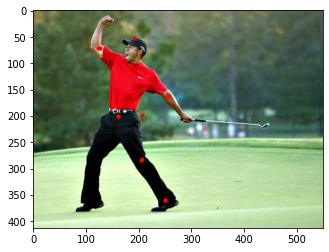

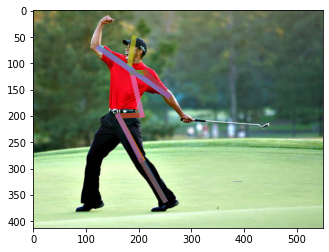

In [31]:
# 스트 이미지를 이용해 모델의 성능 확인
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

# simplebaseline

In [33]:
resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')

94781440/94765736 [==============================] - 0s 0us/step


In [34]:
upconv1 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn1 = tf.keras.layers.BatchNormalization()
relu1 = tf.keras.layers.ReLU()
upconv2 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn2 = tf.keras.layers.BatchNormalization()
relu2 = tf.keras.layers.ReLU()
upconv3 = tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')
bn3 = tf.keras.layers.BatchNormalization()
relu3 = tf.keras.layers.ReLU()

In [35]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

upconv = _make_deconv_layer(3)
final_layer = tf.keras.layers.Conv2D(16, kernel_size=(1,1), padding='same')

In [36]:
from tensorflow import keras

inputs = keras.Input(shape=(256, 256, 3))
x = resnet(inputs)
x = upconv(x)
out = final_layer(x)
model = keras.Model(inputs, out)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [37]:
np_input = np.zeros((1,256,256,3), dtype=np.float32)
tf_input = tf.convert_to_tensor(np_input, dtype=tf.float32)
print('input shape')
print (tf_input.shape)
print('\n')

tf_output = model(tf_input)
print('output shape')
print (tf_output.shape)
print (tf_output)

input shape
(1, 256, 256, 3)


output shape
(1, 64, 64, 16)
tf.Tensor(
[[[[ 8.1029320e-03 -1.5578655e-03  1.2331853e-04 ... -3.1136628e-03
     2.3518853e-04  3.6388226e-03]
   [-1.0283253e-02  3.2568260e-03  3.3530023e-02 ... -5.9978603e-03
    -5.2200919e-03  7.1002110e-03]
   [-7.4236179e-03 -5.4519679e-03 -9.3216067e-03 ... -3.3168239e-03
    -5.9267681e-05  7.3093032e-03]
   ...
   [ 1.9996697e-03  2.4007423e-02  1.8313577e-02 ...  1.3646987e-02
    -2.3890808e-02 -8.4457612e-03]
   [ 6.5291822e-03 -1.3944256e-03  9.8870713e-03 ...  1.8842977e-03
    -1.7062815e-02  8.3060628e-03]
   [ 4.8704008e-03  1.0261943e-02  1.2551290e-02 ...  3.5774589e-03
    -1.2594842e-02 -3.7560386e-03]]

  [[ 6.1431713e-03  7.5562960e-03  1.3027805e-03 ...  9.4922073e-03
    -9.9871671e-03 -6.4474284e-03]
   [ 5.5780420e-03  2.2642156e-02  1.8777031e-02 ...  3.7814695e-03
    -1.3954410e-02 -5.3976462e-03]
   [ 2.5570642e-02  2.3934662e-02 -8.5755903e-03 ... -1.4907127e-03
    -3.6819506e-02 -4.483188

In [38]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = keras.Model(inputs, out)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [31]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007


/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_832/3247077786.py:53 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_832/3247077786.py:44 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/p

TypeError: in user code:

    /tmp/ipykernel_832/3247077786.py:75 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_832/3247077786.py:53 train_step  *
        loss = self.compute_loss(labels, outputs)
    /tmp/ipykernel_832/3247077786.py:44 compute_loss  *
        loss += tf.math.reduce_mean(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1383 binary_op_wrapper
        raise e
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1367 binary_op_wrapper
        return func(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:206 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/math_ops.py:1700 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_math_ops.py:464 add_v2
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/op_def_library.py:555 _apply_op_helper
        raise TypeError(

    TypeError: Input 'y' of 'AddV2' Op has type float32 that does not match type int32 of argument 'x'.


In [31]:
# dtype 에러가 발생한다..

In [39]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/simplebaseline_model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [40]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [41]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = keras.Model(inputs, out)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [31]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
model = keras.Model(inputs, out)

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
INFO:tensorflow:Error reported to Coordinator: in user code:

    /tmp/ipykernel_2204/3096613398.py:57 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStra

ValueError: in user code:

    /tmp/ipykernel_2204/3096613398.py:75 distributed_train_epoch  *
        per_replica_loss = self.strategy.run(
    /tmp/ipykernel_2204/3096613398.py:57 train_step  *
        self.optimizer.apply_gradients(
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:628 apply_gradients  **
        self._create_all_weights(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:815 _create_all_weights
        self._create_slots(var_list)
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:117 _create_slots
        self.add_slot(var, 'm')
    /opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:892 add_slot
        raise ValueError(

    ValueError: Trying to create optimizer slot variable under the scope for tf.distribute.Strategy (<tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x79c268046790>), which is different from the scope used for the original variable (<tf.Variable 'conv1_conv/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
    array([[[[ 2.82526277e-02, -1.18737184e-02,  1.51488732e-03, ...,
              -1.07003953e-02, -5.27982824e-02, -1.36667420e-03],
             [ 5.86827798e-03,  5.04415408e-02,  3.46324709e-03, ...,
               1.01423981e-02,  1.39493728e-02,  1.67549420e-02],
             [-2.44090753e-03, -4.86173332e-02,  2.69966386e-03, ...,
              -3.44439060e-04,  3.48098315e-02,  6.28910400e-03]],
    
            [[ 1.81872323e-02, -7.20698107e-03,  4.80302610e-03, ...,
              -7.43396254e-03, -8.56800564e-03,  1.16849300e-02],
             [ 1.87554304e-02,  5.12730293e-02,  4.50406177e-03, ...,
               1.39413681e-02,  1.26296384e-02, -1.73004344e-02],
             [ 1.90453827e-02, -3.87909152e-02,  4.25842637e-03, ...,
               2.75742816e-04, -1.27962548e-02, -8.35626759e-03]],
    
            [[ 1.58849321e-02, -1.06073255e-02,  1.30999666e-02, ...,
              -2.26797583e-03, -3.98984266e-04,  3.39989027e-04],
             [ 3.61421369e-02,  5.02430499e-02,  1.22699486e-02, ...,
               1.19910473e-02,  2.02837810e-02, -1.96981970e-02],
             [ 2.17959806e-02, -3.86004597e-02,  1.12379901e-02, ...,
              -2.07756506e-03, -3.40645364e-03, -3.78638096e-02]],
    
            ...,
    
            [[-5.30153252e-02, -8.60502943e-03,  6.38643000e-03, ...,
              -4.49256925e-03,  3.48024699e-03, -1.40979560e-02],
             [-9.35578942e-02,  4.61557060e-02,  1.53722311e-03, ...,
               1.21013075e-02,  5.05337631e-03,  3.30474339e-02],
             [-7.69589692e-02, -3.51354294e-02,  2.22769519e-03, ...,
               9.18304977e-06, -1.15465783e-02,  2.29630154e-02]],
    
            [[-4.73558307e-02, -4.07940615e-03,  4.76515992e-03, ...,
              -9.73805040e-03, -1.03890402e-02,  1.62366014e-02],
             [-1.24100089e-01,  4.78516519e-02, -9.90210217e-04, ...,
               1.10340826e-02, -6.77202828e-03,  5.49102016e-02],
             [-7.13113099e-02, -2.86470409e-02,  6.20829698e-04, ...,
              -2.17762636e-03, -1.58942658e-02,  3.44766974e-02]],
    
            [[ 1.85429510e-02, -1.12518407e-02,  1.12506151e-02, ...,
              -1.51338596e-02, -5.66656142e-03, -1.30050071e-02],
             [-2.68079005e-02,  3.64737920e-02,  4.55197273e-03, ...,
               5.53486776e-03,  1.12653999e-02,  2.46754289e-03],
             [ 1.43940765e-02, -3.56382579e-02,  5.08728763e-03, ...,
              -7.46753719e-03,  1.61169283e-02,  1.12382937e-02]]],
    
    
           [[[ 7.99009297e-03, -9.49061289e-03, -4.21846565e-03, ...,
              -1.23715792e-02, -3.82804796e-02, -5.90979494e-03],
             [-7.68794632e-03,  5.46954982e-02, -1.03303632e-02, ...,
               1.40626412e-02,  1.99436247e-02,  2.51518637e-02],
             [ 3.70471564e-04, -3.70203964e-02, -9.80611611e-03, ...,
              -4.95379185e-03,  2.27415562e-02,  1.38941938e-02]],
    
            [[ 2.48856675e-02, -9.57963988e-03, -2.37837038e-03, ...,
              -1.08526833e-02,  2.24138368e-02, -2.40965877e-02],
             [ 2.42966190e-02,  4.93442900e-02, -1.32921906e-02, ...,
               1.47738317e-02,  2.67323572e-02,  1.14357602e-02],
             [ 2.91274227e-02, -3.05654686e-02, -1.42364930e-02, ...,
              -8.36174563e-03, -3.00847553e-02, -2.51545687e-03]],
    
            [[ 7.67260045e-02, -1.19650066e-02, -2.10191216e-03, ...,
               1.79589365e-03,  2.02653632e-02, -1.33340694e-02],
             [ 1.49444759e-01,  5.00719361e-02, -1.52172269e-02, ...,
               1.83409695e-02,  1.56401172e-02,  8.53796005e-02],
             [ 1.17180273e-01, -2.56576538e-02, -1.85890812e-02, ...,
              -2.50462536e-03, -5.22738546e-02,  1.17943510e-02]],
    
            ...,
    
            [[-1.89151186e-02, -1.06457584e-02, -1.19606184e-03, ...,
              -7.13960640e-03,  7.56816342e-02,  8.62411484e-02],
             [ 1.33888470e-02,  4.24321182e-02, -1.93305630e-02, ...,
               8.93499516e-03,  3.26688178e-02,  1.71118364e-01],
             [-9.38678440e-03, -2.88689751e-02, -1.87061988e-02, ...,
              -1.06920488e-02, -4.56195511e-02,  1.51734307e-01]],
    
            [[-7.93561861e-02, -8.69292021e-03,  1.06180850e-02, ...,
              -8.22936464e-03,  5.34521677e-02,  2.43676770e-02],
             [-1.76872283e-01,  4.03351039e-02, -6.91946782e-03, ...,
               1.14902109e-02,  2.45164465e-02,  1.30252065e-02],
             [-1.30214587e-01, -2.94868350e-02, -1.32359739e-03, ...,
              -8.08166154e-03, -3.32693383e-02,  1.78283844e-02]],
    
            [[-1.53617216e-02, -1.02823023e-02,  1.44553250e-02, ...,
              -1.23689836e-02,  2.81683691e-02, -1.52645903e-02],
             [-1.22947149e-01,  3.72432098e-02, -2.82740779e-03, ...,
               1.07275983e-02,  1.61965452e-02, -4.08420824e-02],
             [-7.92325959e-02, -3.09139602e-02,  1.91061670e-04, ...,
              -1.06926244e-02, -1.36199640e-02, -2.90216487e-02]]],
    
    
           [[[-2.74732877e-02, -1.59629062e-02,  5.87167032e-03, ...,
              -1.18064405e-02, -5.19699305e-02, -1.52737210e-02],
             [-7.46604949e-02,  5.22083789e-02, -1.98963331e-03, ...,
               1.27452025e-02,  7.53643783e-03, -1.96208209e-02],
             [-3.34048420e-02, -3.39833461e-02, -1.99538236e-03, ...,
              -9.30251833e-03,  3.30174603e-02, -1.65446047e-02]],
    
            [[-6.57535121e-02, -1.23513499e-02, -4.16519074e-03, ...,
              -1.22041989e-03,  2.09396798e-02,  3.62350084e-02],
             [-1.52494013e-01,  4.94739972e-02, -1.83443855e-02, ...,
               2.37025358e-02,  2.67230812e-02,  8.47681686e-02],
             [-8.80744159e-02, -2.57136654e-02, -2.17252262e-02, ...,
              -3.12197860e-03, -2.06513535e-02,  6.63726628e-02]],
    
            [[ 1.99921392e-02, -1.76080931e-02,  1.81755237e-03, ...,
               3.69562432e-02,  3.51557694e-02,  1.03931516e-01],
             [ 6.10242449e-02,  4.46803048e-02, -1.41719123e-02, ...,
               5.15808910e-02,  2.07974892e-02,  1.46060020e-01],
             [ 8.05315524e-02, -2.88072433e-02, -1.85981095e-02, ...,
               2.20173039e-02, -5.11762947e-02,  1.40093669e-01]],
    
            ...,
    
            [[ 1.15528561e-01, -1.67486407e-02,  8.49904679e-03, ...,
               4.99674492e-03,  7.98972845e-02, -1.11083500e-01],
             [ 3.32334489e-01,  4.24566194e-02, -9.70878359e-03, ...,
               1.92873720e-02,  1.25060824e-03, -3.40990961e-01],
             [ 2.16480315e-01, -2.68480480e-02, -8.96557700e-03, ...,
              -6.44540135e-03, -7.85448179e-02, -2.04899684e-01]],
    
            [[-8.99803787e-02, -8.51823762e-03,  2.25046948e-02, ...,
              -8.74274992e-04,  6.35959804e-02, -9.58404392e-02],
             [-8.15074593e-02,  4.37885672e-02,  3.69152403e-03, ...,
               1.71142723e-02,  6.33937493e-03, -2.73919165e-01],
             [-9.73245725e-02, -2.61962153e-02,  8.95403326e-03, ...,
              -7.23934872e-03, -5.64266555e-02, -1.84837982e-01]],
    
            [[-9.46454927e-02, -1.17739988e-02,  2.49665454e-02, ...,
              -7.38179125e-03,  3.05740479e-02, -1.17530329e-02],
             [-2.11111471e-01,  3.85808311e-02,  5.31885307e-03, ...,
               1.61544569e-02,  3.10361455e-03, -8.36645439e-02],
             [-1.75075874e-01, -3.21811885e-02,  9.45197884e-03, ...,
              -1.05473688e-02, -2.80730613e-02, -6.67640790e-02]]],
    
    
           ...,
    
    
           [[[ 2.31804699e-02, -1.62718501e-02,  1.22078890e-02, ...,
              -1.22131845e-02, -2.02786643e-02, -2.14508991e-03],
             [ 2.30488200e-02,  4.41800952e-02,  3.59291583e-03, ...,
               1.27932075e-02,  6.47032401e-03, -5.39429188e-02],
             [ 2.03978457e-02, -2.67958529e-02,  5.69844292e-03, ...,
              -8.20858125e-03,  2.51460597e-02, -3.12512405e-02]],
    
            [[-4.64516319e-02, -1.34653188e-02,  1.61393601e-02, ...,
              -2.20572166e-02,  5.05596139e-02,  1.47165358e-03],
             [-1.77852944e-01,  4.04180661e-02,  4.32515051e-03, ...,
               7.27979047e-03,  1.37663782e-02, -5.00506982e-02],
             [-1.09063022e-01, -2.11244933e-02,  6.98045455e-03, ...,
              -2.00869981e-02, -6.30094185e-02, -4.20499854e-02]],
    
            [[-1.83006614e-01, -1.79655701e-02,  1.82811301e-02, ...,
               1.56401389e-03,  9.29453745e-02,  4.12672907e-02],
             [-4.11783189e-01,  3.40776965e-02,  8.74394365e-03, ...,
               2.33494844e-02,  1.98237225e-02,  8.06325078e-02],
             [-2.76736170e-01, -2.83147153e-02,  1.31541817e-02, ...,
              -5.05925808e-03, -8.54580775e-02,  4.26753834e-02]],
    
            ...,
    
            [[ 5.36167026e-02, -1.07590063e-02,  2.19804980e-02, ...,
              -8.83348845e-03,  1.40453711e-01,  3.20528477e-01],
             [ 1.85792699e-01,  3.76442447e-02,  1.02089429e-02, ...,
               1.29263047e-02, -3.70457745e-03,  6.66479290e-01],
             [ 1.32038444e-01, -2.75047179e-02,  2.28339490e-02, ...,
              -1.19996015e-02, -1.22367747e-01,  4.83815670e-01]],
    
            [[ 8.34956467e-02, -9.09057911e-03,  2.50242520e-02, ...,
              -1.67011786e-02,  1.20522320e-01,  1.36462688e-01],
             [ 2.50555605e-01,  4.07686047e-02,  1.08884834e-02, ...,
               7.53540406e-03, -7.55708572e-03,  3.96415204e-01],
             [ 1.49690762e-01, -3.11034787e-02,  2.43526250e-02, ...,
              -1.65321939e-02, -1.09688722e-01,  2.64446586e-01]],
    
            [[ 3.69576029e-02, -1.27014471e-02,  3.19833457e-02, ...,
              -1.48784053e-02,  9.22970548e-02,  6.54868260e-02],
             [ 9.63706747e-02,  4.39107306e-02,  1.59802549e-02, ...,
               1.22494521e-02,  8.10312852e-03,  1.78935930e-01],
             [ 2.95156911e-02, -2.96487771e-02,  2.69996542e-02, ...,
              -1.38547905e-02, -7.72434175e-02,  1.32773802e-01]]],
    
    
           [[[ 4.22548056e-02, -8.30464344e-03,  5.34065207e-03, ...,
              -8.06468353e-03, -4.70053628e-02,  4.45614867e-02],
             [ 9.77012664e-02,  3.83502319e-02, -5.37837343e-03, ...,
               1.17106764e-02, -4.59602941e-03,  6.98771998e-02],
             [ 6.38262108e-02, -2.08319575e-02, -1.72756368e-03, ...,
              -8.19445588e-03,  4.25621867e-02,  4.83920909e-02]],
    
            [[ 4.59470600e-02, -4.77699284e-03,  7.04339007e-03, ...,
              -1.82104297e-02,  3.14848162e-02,  4.64068204e-02],
             [ 3.89483608e-02,  3.78783308e-02, -6.85291924e-03, ...,
               7.33014196e-03,  3.90656322e-04,  1.52848229e-01],
             [ 4.57218140e-02, -1.34090437e-02, -8.30697361e-04, ...,
              -1.85202472e-02, -3.45353335e-02,  9.25581828e-02]],
    
            [[-4.66161780e-02, -1.22223441e-02,  9.35023464e-03, ...,
              -1.31351836e-02,  6.08736612e-02,  9.18865502e-02],
             [-1.92336142e-01,  3.18407975e-02, -1.01881009e-03, ...,
               7.55425170e-03, -8.62357323e-04,  2.88297594e-01],
             [-1.15666650e-01, -2.35320851e-02,  6.74636895e-03, ...,
              -1.94703583e-02, -5.66169359e-02,  1.95824102e-01]],
    
            ...,
    
            [[-2.10239179e-02, -9.81471874e-03,  9.81596112e-03, ...,
              -1.36731779e-02,  1.20193027e-01, -1.26708716e-01],
             [-3.72992679e-02,  3.05935629e-02, -3.00194928e-03, ...,
               8.85152724e-03, -5.07611316e-03, -6.25461042e-02],
             [ 7.84674310e-04, -2.91344281e-02,  1.12569630e-02, ...,
              -1.38232643e-02, -9.49400812e-02, -8.74437019e-02]],
    
            [[ 3.32221799e-02, -4.22911346e-03,  1.13633750e-02, ...,
              -1.41841583e-02,  9.59840789e-02, -1.23203963e-01],
             [ 9.95653942e-02,  4.03233357e-02, -4.36036801e-03, ...,
               8.42505507e-03, -1.50266392e-02, -1.58158958e-01],
             [ 6.55353814e-02, -2.76978761e-02,  1.06595978e-02, ...,
              -1.31017175e-02, -9.93799716e-02, -1.52014121e-01]],
    
            [[ 2.50522885e-02, -1.08845932e-02,  1.29567981e-02, ...,
              -1.67823900e-02,  6.55406937e-02, -3.34061496e-02],
             [ 1.00219429e-01,  4.24924381e-02, -4.06364352e-03, ...,
               8.98410939e-03, -1.98677508e-03, -9.19047296e-02],
             [ 6.97101504e-02, -3.41515057e-02,  8.97936709e-03, ...,
              -1.51484888e-02, -8.06454644e-02, -8.53376985e-02]]],
    
    
           [[[ 1.46303158e-02, -9.15218703e-03,  5.24803856e-03, ...,
              -3.63799883e-03, -5.51798902e-02, -7.19531113e-03],
             [ 6.12211153e-02,  2.67034862e-02, -4.38000960e-03, ...,
               1.38858845e-02,  1.62421225e-03,  6.91889692e-03],
             [ 1.86353922e-02, -2.39325576e-02,  5.56383107e-04, ...,
              -6.68733614e-03,  7.36468807e-02,  3.71867418e-02]],
    
            [[ 3.52302976e-02, -3.27857491e-03,  7.14091491e-03, ...,
              -9.93822515e-03,  2.38756705e-02, -2.10771449e-02],
             [ 6.34438619e-02,  3.12160589e-02, -7.72275496e-03, ...,
               1.49217555e-02,  3.86624038e-03, -1.16395289e-02],
             [ 3.35849188e-02, -1.63664240e-02, -1.32562651e-03, ...,
              -1.30512416e-02, -7.29435496e-03, -1.24825155e-02]],
    
            [[ 4.10873676e-03, -4.66612726e-03,  1.21031692e-02, ...,
              -7.87103828e-03,  5.80726229e-02, -4.19587009e-02],
             [-2.23153979e-02,  2.99241953e-02,  8.01213668e-04, ...,
               1.82199273e-02,  9.57238674e-03, -8.57376456e-02],
             [-2.01183017e-02, -1.96383689e-02,  7.32050464e-03, ...,
              -1.07293837e-02, -2.17854325e-02, -7.95444921e-02]],
    
            ...,
    
            [[-1.71692297e-02, -3.16392444e-03,  2.40169745e-03, ...,
              -9.67177004e-03,  9.26117748e-02, -1.16062798e-02],
             [-8.63026828e-02,  3.55335064e-02, -1.06153013e-02, ...,
               1.85809545e-02, -2.19932254e-02, -1.47949710e-01],
             [-6.07556999e-02, -2.66596545e-02,  1.74473948e-03, ...,
              -4.85855900e-03, -8.82942155e-02, -8.43590796e-02]],
    
            [[ 1.15142548e-02,  2.20947526e-03,  5.08834422e-03, ...,
              -1.04352133e-02,  6.78158402e-02,  4.14623357e-02],
             [ 7.41827395e-03,  4.52373996e-02, -1.10873608e-02, ...,
               1.56368576e-02, -2.37460397e-02, -3.25448737e-02],
             [ 7.84576032e-03, -2.45320965e-02,  5.84031455e-04, ...,
              -8.31448287e-03, -8.92601907e-02, -3.36888898e-03]],
    
            [[ 4.79146978e-03, -4.22942545e-03,  1.15078716e-02, ...,
              -2.12721284e-02,  4.96782959e-02,  2.05268860e-02],
             [ 2.75192987e-02,  4.36737053e-02, -5.71439136e-03, ...,
               9.46100149e-03, -8.58635467e-04, -1.79863740e-02],
             [ 2.71184333e-02, -3.31169143e-02,  3.97488568e-03, ...,
              -1.41424611e-02, -6.35233149e-02,  1.29984575e-03]]]],
          dtype=float32)>). Make sure the slot variables are created under the same strategy scope. This may happen if you're restoring from a checkpoint outside the scope


In [32]:
# 모델이 밖에서 선언되었다는 메시지다.
# def으로 모델 생성 함수를 만들어 내부에서 호출하도록 해야할 것 같다.
# 이생각 하는데 3시간이 걸렸다는...

In [42]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0.0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/simplebaseline_model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [43]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [44]:
from tensorflow import keras

def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

def simplebaseline_model(input_shape=(256, 256, 3),
                         num_stack=3, 
                         num_heatmap=16):
    resnet = tf.keras.applications.resnet.ResNet50(include_top=False, weights='imagenet')
    
    upconv = _make_deconv_layer(num_stack)
    final_layer = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')
    
    inputs = keras.Input(shape=input_shape)
    x = resnet(inputs)
    x = upconv(x)
    out = final_layer(x)
    
    return keras.Model(inputs, out)  
    
    

In [45]:
simplebaseline_model().summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


In [46]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = simplebaseline_model()

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [20]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007
model = simplebaseline_model()

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 1 batch loss 10.7244587 epoch total loss 10.7244587
Trained batch 2 batch loss 11.3415661 epoch total loss 11.0330124
Trained batch 3 batch loss 9.46085835 epoch total loss 10.5089607
Trained batch 4 batch loss 8.64404869 epoch total loss 10.0427322
Trained batch 5 batch loss 7.75864363 epoch total loss 9.58591461
Trained batch 6 batch loss 7.60032368 epoch total loss 9.25498295
Trained batch 7 batch loss 7.15584564 epoch total loss 8.95510578
Trained batch 8 batch loss 6.97844648 epoch total loss 8.70802307
Trained batch 9 batch loss 6.90503788 epoch total loss 8.50769138
Trained batch 10 batch loss 7.13323641 epoch total loss 8.37024593
Trained batch 11 batch loss 6.72354364 epoch total loss 8.22054577
Trained batch 12 batch loss 6.76198769 epoch total loss 8.09899902
Trained batch 13 batch loss 6.72018194 epoch total loss 7.99293613
Trained batch 14 batch loss 6.31946564 epoch total loss 7.8734026
Trained batch 15 batch loss 6.7305913 epo

Trained batch 124 batch loss 6.70883179 epoch total loss 6.5472784
Trained batch 125 batch loss 6.4540658 epoch total loss 6.54653263
Trained batch 126 batch loss 6.40398073 epoch total loss 6.54540157
Trained batch 127 batch loss 6.92113638 epoch total loss 6.54836
Trained batch 128 batch loss 6.7236414 epoch total loss 6.54972935
Trained batch 129 batch loss 6.05535936 epoch total loss 6.54589701
Trained batch 130 batch loss 6.26304 epoch total loss 6.5437212
Trained batch 131 batch loss 6.67791939 epoch total loss 6.54474592
Trained batch 132 batch loss 6.57366657 epoch total loss 6.54496479
Trained batch 133 batch loss 6.5288353 epoch total loss 6.5448432
Trained batch 134 batch loss 6.54491282 epoch total loss 6.54484415
Trained batch 135 batch loss 6.44368172 epoch total loss 6.54409456
Trained batch 136 batch loss 6.51075506 epoch total loss 6.54384947
Trained batch 137 batch loss 6.7775054 epoch total loss 6.54555511
Trained batch 138 batch loss 6.53580618 epoch total loss 6.54

Trained batch 246 batch loss 6.40397167 epoch total loss 6.51851511
Trained batch 247 batch loss 6.32648754 epoch total loss 6.51773787
Trained batch 248 batch loss 6.65907478 epoch total loss 6.51830769
Trained batch 249 batch loss 6.53419256 epoch total loss 6.51837111
Trained batch 250 batch loss 6.48020506 epoch total loss 6.51821852
Trained batch 251 batch loss 6.58515263 epoch total loss 6.51848555
Trained batch 252 batch loss 6.64919281 epoch total loss 6.51900434
Trained batch 253 batch loss 6.70398092 epoch total loss 6.51973534
Trained batch 254 batch loss 6.71149921 epoch total loss 6.52049065
Trained batch 255 batch loss 6.45088482 epoch total loss 6.5202179
Trained batch 256 batch loss 6.42233658 epoch total loss 6.51983547
Trained batch 257 batch loss 5.94086409 epoch total loss 6.51758289
Trained batch 258 batch loss 6.41949844 epoch total loss 6.51720285
Trained batch 259 batch loss 6.36343765 epoch total loss 6.51660919
Trained batch 260 batch loss 5.93710709 epoch tot

Trained batch 368 batch loss 6.07728243 epoch total loss 6.49403572
Trained batch 369 batch loss 5.99033356 epoch total loss 6.49267054
Trained batch 370 batch loss 6.70027733 epoch total loss 6.4932313
Trained batch 371 batch loss 6.32056522 epoch total loss 6.4927659
Trained batch 372 batch loss 6.05866098 epoch total loss 6.49159861
Trained batch 373 batch loss 5.82338238 epoch total loss 6.48980761
Trained batch 374 batch loss 5.80539417 epoch total loss 6.4879775
Trained batch 375 batch loss 5.81084871 epoch total loss 6.48617172
Trained batch 376 batch loss 6.08776331 epoch total loss 6.48511219
Trained batch 377 batch loss 6.21330452 epoch total loss 6.48439121
Trained batch 378 batch loss 6.77974129 epoch total loss 6.48517275
Trained batch 379 batch loss 6.70380497 epoch total loss 6.48574972
Trained batch 380 batch loss 6.52264404 epoch total loss 6.485847
Trained batch 381 batch loss 6.51249361 epoch total loss 6.48591661
Trained batch 382 batch loss 6.54842281 epoch total l

Trained batch 490 batch loss 6.10022259 epoch total loss 6.46032286
Trained batch 491 batch loss 6.02439737 epoch total loss 6.45943499
Trained batch 492 batch loss 6.33848715 epoch total loss 6.45918894
Trained batch 493 batch loss 6.5986867 epoch total loss 6.4594717
Trained batch 494 batch loss 6.43330288 epoch total loss 6.45941877
Trained batch 495 batch loss 6.18292093 epoch total loss 6.45886
Trained batch 496 batch loss 6.16198492 epoch total loss 6.45826149
Trained batch 497 batch loss 6.3616128 epoch total loss 6.45806694
Trained batch 498 batch loss 6.34563255 epoch total loss 6.45784092
Trained batch 499 batch loss 6.29885101 epoch total loss 6.45752239
Trained batch 500 batch loss 6.52973938 epoch total loss 6.45766687
Trained batch 501 batch loss 6.62280798 epoch total loss 6.45799637
Trained batch 502 batch loss 6.58091974 epoch total loss 6.45824146
Trained batch 503 batch loss 6.48429775 epoch total loss 6.45829344
Trained batch 504 batch loss 6.51104546 epoch total lo

Trained batch 612 batch loss 6.45347929 epoch total loss 6.43726683
Trained batch 613 batch loss 6.33566952 epoch total loss 6.43710089
Trained batch 614 batch loss 6.46396542 epoch total loss 6.43714476
Trained batch 615 batch loss 6.31719255 epoch total loss 6.43694925
Trained batch 616 batch loss 6.3629961 epoch total loss 6.43682957
Trained batch 617 batch loss 6.56248474 epoch total loss 6.43703318
Trained batch 618 batch loss 6.29229927 epoch total loss 6.43679857
Trained batch 619 batch loss 6.18394041 epoch total loss 6.43639
Trained batch 620 batch loss 5.98840666 epoch total loss 6.43566799
Trained batch 621 batch loss 6.31979465 epoch total loss 6.43548107
Trained batch 622 batch loss 6.39525795 epoch total loss 6.4354167
Trained batch 623 batch loss 6.50870371 epoch total loss 6.43553448
Trained batch 624 batch loss 6.87809372 epoch total loss 6.43624353
Trained batch 625 batch loss 6.65472651 epoch total loss 6.43659353
Trained batch 626 batch loss 6.36683226 epoch total l

Trained batch 734 batch loss 6.66672325 epoch total loss 6.44580603
Trained batch 735 batch loss 5.98295355 epoch total loss 6.44517612
Trained batch 736 batch loss 6.18919134 epoch total loss 6.44482803
Trained batch 737 batch loss 6.41000175 epoch total loss 6.4447813
Trained batch 738 batch loss 6.53338909 epoch total loss 6.44490099
Trained batch 739 batch loss 6.48326206 epoch total loss 6.44495296
Trained batch 740 batch loss 6.48994255 epoch total loss 6.44501352
Trained batch 741 batch loss 6.72002602 epoch total loss 6.44538498
Trained batch 742 batch loss 6.56839752 epoch total loss 6.44555092
Trained batch 743 batch loss 6.67914963 epoch total loss 6.44586515
Trained batch 744 batch loss 6.64471436 epoch total loss 6.44613218
Trained batch 745 batch loss 6.65896511 epoch total loss 6.44641829
Trained batch 746 batch loss 6.50665188 epoch total loss 6.44649935
Trained batch 747 batch loss 6.42841339 epoch total loss 6.44647455
Trained batch 748 batch loss 6.61819363 epoch tot

Trained batch 856 batch loss 6.22869158 epoch total loss 6.45013428
Trained batch 857 batch loss 6.43684959 epoch total loss 6.45011902
Trained batch 858 batch loss 6.50146103 epoch total loss 6.45017862
Trained batch 859 batch loss 6.65205956 epoch total loss 6.4504137
Trained batch 860 batch loss 6.69370317 epoch total loss 6.45069647
Trained batch 861 batch loss 6.79820728 epoch total loss 6.45110035
Trained batch 862 batch loss 6.88587379 epoch total loss 6.45160484
Trained batch 863 batch loss 6.70349 epoch total loss 6.45189667
Trained batch 864 batch loss 6.50441551 epoch total loss 6.45195723
Trained batch 865 batch loss 6.45339298 epoch total loss 6.45195913
Trained batch 866 batch loss 6.45933676 epoch total loss 6.45196819
Trained batch 867 batch loss 6.49085665 epoch total loss 6.45201254
Trained batch 868 batch loss 6.04433966 epoch total loss 6.45154333
Trained batch 869 batch loss 6.31609535 epoch total loss 6.45138693
Trained batch 870 batch loss 6.66116714 epoch total 

Trained batch 978 batch loss 6.4730792 epoch total loss 6.44236135
Trained batch 979 batch loss 6.26519728 epoch total loss 6.44218
Trained batch 980 batch loss 6.3218832 epoch total loss 6.44205761
Trained batch 981 batch loss 6.44820404 epoch total loss 6.44206381
Trained batch 982 batch loss 6.04478 epoch total loss 6.44165945
Trained batch 983 batch loss 6.26638746 epoch total loss 6.44148111
Trained batch 984 batch loss 6.03773928 epoch total loss 6.44107103
Trained batch 985 batch loss 6.17295408 epoch total loss 6.44079828
Trained batch 986 batch loss 6.35797787 epoch total loss 6.44071436
Trained batch 987 batch loss 6.55974579 epoch total loss 6.440835
Trained batch 988 batch loss 6.32791948 epoch total loss 6.44072056
Trained batch 989 batch loss 6.53827477 epoch total loss 6.44081926
Trained batch 990 batch loss 6.58580589 epoch total loss 6.44096565
Trained batch 991 batch loss 6.76269102 epoch total loss 6.44129038
Trained batch 992 batch loss 6.11046 epoch total loss 6.44

Trained batch 1098 batch loss 6.2080822 epoch total loss 6.44138288
Trained batch 1099 batch loss 6.39117622 epoch total loss 6.44133711
Trained batch 1100 batch loss 6.56128359 epoch total loss 6.4414463
Trained batch 1101 batch loss 6.94714785 epoch total loss 6.4419055
Trained batch 1102 batch loss 6.60864687 epoch total loss 6.44205713
Trained batch 1103 batch loss 6.17754936 epoch total loss 6.44181728
Trained batch 1104 batch loss 6.24183 epoch total loss 6.44163609
Trained batch 1105 batch loss 5.96993876 epoch total loss 6.44120932
Trained batch 1106 batch loss 6.2420764 epoch total loss 6.44102907
Trained batch 1107 batch loss 6.24594879 epoch total loss 6.44085312
Trained batch 1108 batch loss 6.31635523 epoch total loss 6.44074059
Trained batch 1109 batch loss 6.23468781 epoch total loss 6.4405551
Trained batch 1110 batch loss 6.60961437 epoch total loss 6.44070721
Trained batch 1111 batch loss 6.74710083 epoch total loss 6.44098282
Trained batch 1112 batch loss 6.89699316 e

Trained batch 1218 batch loss 6.26935434 epoch total loss 6.4340539
Trained batch 1219 batch loss 6.16562414 epoch total loss 6.4338336
Trained batch 1220 batch loss 5.94750357 epoch total loss 6.43343496
Trained batch 1221 batch loss 6.19745064 epoch total loss 6.43324137
Trained batch 1222 batch loss 6.1795 epoch total loss 6.43303394
Trained batch 1223 batch loss 6.20523548 epoch total loss 6.4328475
Trained batch 1224 batch loss 5.99611568 epoch total loss 6.43249083
Trained batch 1225 batch loss 5.79685354 epoch total loss 6.43197203
Trained batch 1226 batch loss 5.78448868 epoch total loss 6.43144369
Trained batch 1227 batch loss 5.48105621 epoch total loss 6.43066931
Trained batch 1228 batch loss 6.02321 epoch total loss 6.43033743
Trained batch 1229 batch loss 6.38578367 epoch total loss 6.43030119
Trained batch 1230 batch loss 6.15650225 epoch total loss 6.43007898
Trained batch 1231 batch loss 6.31691694 epoch total loss 6.42998695
Trained batch 1232 batch loss 6.52813053 epo

Trained batch 1338 batch loss 6.25042629 epoch total loss 6.41894913
Trained batch 1339 batch loss 6.58372116 epoch total loss 6.41907215
Trained batch 1340 batch loss 6.79872131 epoch total loss 6.41935539
Trained batch 1341 batch loss 6.91333151 epoch total loss 6.41972399
Trained batch 1342 batch loss 7.42100286 epoch total loss 6.42046976
Trained batch 1343 batch loss 6.57964516 epoch total loss 6.42058849
Trained batch 1344 batch loss 6.49106693 epoch total loss 6.42064142
Trained batch 1345 batch loss 6.44833279 epoch total loss 6.42066193
Trained batch 1346 batch loss 6.313344 epoch total loss 6.42058229
Trained batch 1347 batch loss 6.37582111 epoch total loss 6.42054892
Trained batch 1348 batch loss 6.20883751 epoch total loss 6.42039204
Trained batch 1349 batch loss 6.19728184 epoch total loss 6.42022657
Trained batch 1350 batch loss 6.42793846 epoch total loss 6.4202323
Trained batch 1351 batch loss 6.45408821 epoch total loss 6.42025709
Trained batch 1352 batch loss 6.03534

Validated batch 116 batch loss 6.59942341
Validated batch 117 batch loss 6.4599905
Validated batch 118 batch loss 6.22137451
Validated batch 119 batch loss 6.09299469
Validated batch 120 batch loss 6.21237803
Validated batch 121 batch loss 6.41581392
Validated batch 122 batch loss 6.10210848
Validated batch 123 batch loss 6.38992405
Validated batch 124 batch loss 6.46985579
Validated batch 125 batch loss 6.46022654
Validated batch 126 batch loss 6.22030687
Validated batch 127 batch loss 6.05318499
Validated batch 128 batch loss 6.24820518
Validated batch 129 batch loss 6.71689558
Validated batch 130 batch loss 6.27535677
Validated batch 131 batch loss 6.31961584
Validated batch 132 batch loss 6.2674427
Validated batch 133 batch loss 5.9588685
Validated batch 134 batch loss 5.86595154
Validated batch 135 batch loss 6.40772629
Validated batch 136 batch loss 6.12510395
Validated batch 137 batch loss 6.11883926
Validated batch 138 batch loss 6.352355
Validated batch 139 batch loss 6.303609

Trained batch 78 batch loss 6.11301565 epoch total loss 6.36054659
Trained batch 79 batch loss 6.36627245 epoch total loss 6.36061907
Trained batch 80 batch loss 6.34886789 epoch total loss 6.3604722
Trained batch 81 batch loss 6.30618095 epoch total loss 6.35980129
Trained batch 82 batch loss 6.96661615 epoch total loss 6.36720181
Trained batch 83 batch loss 6.72139597 epoch total loss 6.37146902
Trained batch 84 batch loss 6.42906237 epoch total loss 6.37215471
Trained batch 85 batch loss 5.66032 epoch total loss 6.3637805
Trained batch 86 batch loss 5.827106 epoch total loss 6.35753965
Trained batch 87 batch loss 6.13754177 epoch total loss 6.35501051
Trained batch 88 batch loss 6.50124884 epoch total loss 6.35667229
Trained batch 89 batch loss 6.65870094 epoch total loss 6.36006546
Trained batch 90 batch loss 6.97828627 epoch total loss 6.36693478
Trained batch 91 batch loss 7.21166229 epoch total loss 6.37621737
Trained batch 92 batch loss 7.05504227 epoch total loss 6.38359594
Tr

Trained batch 200 batch loss 5.75640249 epoch total loss 6.37901592
Trained batch 201 batch loss 6.11513138 epoch total loss 6.37770319
Trained batch 202 batch loss 6.05390549 epoch total loss 6.37610054
Trained batch 203 batch loss 6.07348347 epoch total loss 6.37461
Trained batch 204 batch loss 6.3416276 epoch total loss 6.3744483
Trained batch 205 batch loss 6.17630863 epoch total loss 6.37348175
Trained batch 206 batch loss 6.47761297 epoch total loss 6.3739872
Trained batch 207 batch loss 6.15948677 epoch total loss 6.37295151
Trained batch 208 batch loss 6.4013381 epoch total loss 6.37308788
Trained batch 209 batch loss 6.81168509 epoch total loss 6.37518644
Trained batch 210 batch loss 5.84373617 epoch total loss 6.37265587
Trained batch 211 batch loss 4.76462126 epoch total loss 6.36503458
Trained batch 212 batch loss 5.27993 epoch total loss 6.35991621
Trained batch 213 batch loss 5.95301199 epoch total loss 6.358006
Trained batch 214 batch loss 7.35754967 epoch total loss 6.3

Trained batch 322 batch loss 6.48302698 epoch total loss 6.39420748
Trained batch 323 batch loss 6.53614759 epoch total loss 6.39464712
Trained batch 324 batch loss 6.65704918 epoch total loss 6.39545679
Trained batch 325 batch loss 6.62879181 epoch total loss 6.39617491
Trained batch 326 batch loss 6.76320791 epoch total loss 6.39730072
Trained batch 327 batch loss 6.65442181 epoch total loss 6.3980875
Trained batch 328 batch loss 6.75189161 epoch total loss 6.39916611
Trained batch 329 batch loss 6.54497576 epoch total loss 6.39960909
Trained batch 330 batch loss 6.98766184 epoch total loss 6.40139103
Trained batch 331 batch loss 6.77922106 epoch total loss 6.40253258
Trained batch 332 batch loss 6.21194792 epoch total loss 6.40195847
Trained batch 333 batch loss 6.29031181 epoch total loss 6.40162325
Trained batch 334 batch loss 5.96011 epoch total loss 6.40030146
Trained batch 335 batch loss 5.48934126 epoch total loss 6.39758205
Trained batch 336 batch loss 5.97489262 epoch total 

Trained batch 444 batch loss 6.50908566 epoch total loss 6.37885809
Trained batch 445 batch loss 6.43181372 epoch total loss 6.37897682
Trained batch 446 batch loss 5.92159653 epoch total loss 6.37795162
Trained batch 447 batch loss 6.46072 epoch total loss 6.37813663
Trained batch 448 batch loss 6.2350564 epoch total loss 6.37781763
Trained batch 449 batch loss 6.30688429 epoch total loss 6.37765932
Trained batch 450 batch loss 6.35196447 epoch total loss 6.37760258
Trained batch 451 batch loss 6.25443459 epoch total loss 6.37732935
Trained batch 452 batch loss 6.14968395 epoch total loss 6.37682581
Trained batch 453 batch loss 6.48549795 epoch total loss 6.37706566
Trained batch 454 batch loss 6.59768724 epoch total loss 6.37755156
Trained batch 455 batch loss 5.95101738 epoch total loss 6.37661409
Trained batch 456 batch loss 6.39429903 epoch total loss 6.37665272
Trained batch 457 batch loss 5.95575047 epoch total loss 6.37573195
Trained batch 458 batch loss 5.99288177 epoch total 

Trained batch 566 batch loss 6.30791 epoch total loss 6.39414644
Trained batch 567 batch loss 6.30162811 epoch total loss 6.39398289
Trained batch 568 batch loss 5.84476185 epoch total loss 6.39301634
Trained batch 569 batch loss 6.29217577 epoch total loss 6.39283895
Trained batch 570 batch loss 7.25392485 epoch total loss 6.39434958
Trained batch 571 batch loss 6.71924257 epoch total loss 6.39491844
Trained batch 572 batch loss 6.62342167 epoch total loss 6.39531851
Trained batch 573 batch loss 6.98503065 epoch total loss 6.39634752
Trained batch 574 batch loss 6.47191763 epoch total loss 6.39647913
Trained batch 575 batch loss 6.48739815 epoch total loss 6.39663744
Trained batch 576 batch loss 6.43316317 epoch total loss 6.39670038
Trained batch 577 batch loss 6.55977488 epoch total loss 6.39698315
Trained batch 578 batch loss 6.4649992 epoch total loss 6.39710093
Trained batch 579 batch loss 6.3141017 epoch total loss 6.39695787
Trained batch 580 batch loss 6.70376 epoch total loss

Trained batch 688 batch loss 6.816782 epoch total loss 6.38243723
Trained batch 689 batch loss 6.46341848 epoch total loss 6.38255453
Trained batch 690 batch loss 6.31180859 epoch total loss 6.38245249
Trained batch 691 batch loss 6.42572069 epoch total loss 6.38251495
Trained batch 692 batch loss 6.31495667 epoch total loss 6.3824172
Trained batch 693 batch loss 6.646698 epoch total loss 6.38279819
Trained batch 694 batch loss 6.61372614 epoch total loss 6.38313103
Trained batch 695 batch loss 6.78077221 epoch total loss 6.38370323
Trained batch 696 batch loss 5.97571802 epoch total loss 6.3831172
Trained batch 697 batch loss 6.2825942 epoch total loss 6.38297272
Trained batch 698 batch loss 5.92121553 epoch total loss 6.38231182
Trained batch 699 batch loss 6.03349781 epoch total loss 6.38181305
Trained batch 700 batch loss 6.40492392 epoch total loss 6.38184547
Trained batch 701 batch loss 5.74404621 epoch total loss 6.38093615
Trained batch 702 batch loss 5.41142941 epoch total los

Trained batch 810 batch loss 6.07027531 epoch total loss 6.37792
Trained batch 811 batch loss 6.41930771 epoch total loss 6.37797117
Trained batch 812 batch loss 6.55283976 epoch total loss 6.37818623
Trained batch 813 batch loss 6.70164776 epoch total loss 6.37858438
Trained batch 814 batch loss 6.54056215 epoch total loss 6.37878323
Trained batch 815 batch loss 6.03796816 epoch total loss 6.37836504
Trained batch 816 batch loss 6.20955563 epoch total loss 6.37815809
Trained batch 817 batch loss 6.53084278 epoch total loss 6.37834501
Trained batch 818 batch loss 6.41396093 epoch total loss 6.37838888
Trained batch 819 batch loss 6.73483706 epoch total loss 6.37882376
Trained batch 820 batch loss 6.46889639 epoch total loss 6.37893343
Trained batch 821 batch loss 6.44081736 epoch total loss 6.37900925
Trained batch 822 batch loss 5.8173418 epoch total loss 6.37832594
Trained batch 823 batch loss 6.35202074 epoch total loss 6.37829399
Trained batch 824 batch loss 6.91315699 epoch total 

Trained batch 932 batch loss 5.61665535 epoch total loss 6.37335062
Trained batch 933 batch loss 5.76942205 epoch total loss 6.37270355
Trained batch 934 batch loss 6.24823523 epoch total loss 6.37257
Trained batch 935 batch loss 6.37724304 epoch total loss 6.37257528
Trained batch 936 batch loss 6.36640358 epoch total loss 6.37256861
Trained batch 937 batch loss 6.41916037 epoch total loss 6.3726182
Trained batch 938 batch loss 6.41452169 epoch total loss 6.37266254
Trained batch 939 batch loss 6.32374239 epoch total loss 6.37261057
Trained batch 940 batch loss 5.99582863 epoch total loss 6.37220955
Trained batch 941 batch loss 5.61211538 epoch total loss 6.37140179
Trained batch 942 batch loss 5.01833534 epoch total loss 6.36996603
Trained batch 943 batch loss 5.44211674 epoch total loss 6.36898184
Trained batch 944 batch loss 6.07387972 epoch total loss 6.36866903
Trained batch 945 batch loss 6.70523691 epoch total loss 6.36902475
Trained batch 946 batch loss 6.21172619 epoch total 

Trained batch 1053 batch loss 6.36669207 epoch total loss 6.37004375
Trained batch 1054 batch loss 6.25638723 epoch total loss 6.36993599
Trained batch 1055 batch loss 6.05961 epoch total loss 6.36964178
Trained batch 1056 batch loss 6.33477449 epoch total loss 6.36960888
Trained batch 1057 batch loss 6.47109604 epoch total loss 6.3697052
Trained batch 1058 batch loss 6.25965261 epoch total loss 6.36960125
Trained batch 1059 batch loss 6.09459829 epoch total loss 6.36934185
Trained batch 1060 batch loss 6.2628603 epoch total loss 6.36924124
Trained batch 1061 batch loss 6.32438374 epoch total loss 6.3691988
Trained batch 1062 batch loss 6.1521616 epoch total loss 6.36899424
Trained batch 1063 batch loss 6.52296257 epoch total loss 6.36913919
Trained batch 1064 batch loss 6.47830057 epoch total loss 6.36924219
Trained batch 1065 batch loss 6.45310593 epoch total loss 6.36932087
Trained batch 1066 batch loss 6.83023119 epoch total loss 6.36975288
Trained batch 1067 batch loss 6.49060488 

Trained batch 1173 batch loss 6.27877951 epoch total loss 6.37068272
Trained batch 1174 batch loss 6.06385136 epoch total loss 6.37042141
Trained batch 1175 batch loss 6.50065327 epoch total loss 6.37053204
Trained batch 1176 batch loss 6.11283875 epoch total loss 6.37031269
Trained batch 1177 batch loss 6.24143457 epoch total loss 6.37020302
Trained batch 1178 batch loss 5.95496 epoch total loss 6.36985064
Trained batch 1179 batch loss 6.42737913 epoch total loss 6.36989927
Trained batch 1180 batch loss 6.32212591 epoch total loss 6.36985874
Trained batch 1181 batch loss 6.46409 epoch total loss 6.36993837
Trained batch 1182 batch loss 6.71600771 epoch total loss 6.37023115
Trained batch 1183 batch loss 6.19616 epoch total loss 6.37008429
Trained batch 1184 batch loss 5.91375113 epoch total loss 6.36969852
Trained batch 1185 batch loss 6.63279438 epoch total loss 6.36992073
Trained batch 1186 batch loss 6.51313448 epoch total loss 6.37004137
Trained batch 1187 batch loss 6.53436089 ep

Trained batch 1293 batch loss 5.97021484 epoch total loss 6.3677783
Trained batch 1294 batch loss 6.21384954 epoch total loss 6.36765909
Trained batch 1295 batch loss 6.38851 epoch total loss 6.3676753
Trained batch 1296 batch loss 6.46550512 epoch total loss 6.36775112
Trained batch 1297 batch loss 6.50036097 epoch total loss 6.36785316
Trained batch 1298 batch loss 6.54024029 epoch total loss 6.36798573
Trained batch 1299 batch loss 6.7021656 epoch total loss 6.36824322
Trained batch 1300 batch loss 6.57734394 epoch total loss 6.36840391
Trained batch 1301 batch loss 6.56222296 epoch total loss 6.36855268
Trained batch 1302 batch loss 6.66002131 epoch total loss 6.3687768
Trained batch 1303 batch loss 6.0301857 epoch total loss 6.36851692
Trained batch 1304 batch loss 5.91968775 epoch total loss 6.36817312
Trained batch 1305 batch loss 6.47604799 epoch total loss 6.36825514
Trained batch 1306 batch loss 6.49695921 epoch total loss 6.36835384
Trained batch 1307 batch loss 6.26059723 e

Validated batch 40 batch loss 6.35591
Validated batch 41 batch loss 6.40416288
Validated batch 42 batch loss 6.15048313
Validated batch 43 batch loss 6.4275074
Validated batch 44 batch loss 5.9737525
Validated batch 45 batch loss 6.54948282
Validated batch 46 batch loss 6.60977602
Validated batch 47 batch loss 5.85377216
Validated batch 48 batch loss 6.6917367
Validated batch 49 batch loss 6.34179831
Validated batch 50 batch loss 6.53554773
Validated batch 51 batch loss 6.38359737
Validated batch 52 batch loss 6.69207144
Validated batch 53 batch loss 6.16965961
Validated batch 54 batch loss 6.70266533
Validated batch 55 batch loss 6.0956707
Validated batch 56 batch loss 6.39698839
Validated batch 57 batch loss 6.40013313
Validated batch 58 batch loss 5.80464172
Validated batch 59 batch loss 5.733428
Validated batch 60 batch loss 6.52589226
Validated batch 61 batch loss 6.48918533
Validated batch 62 batch loss 6.04877234
Validated batch 63 batch loss 6.50506783
Validated batch 64 batch 

Trained batch 32 batch loss 6.69036865 epoch total loss 6.40844154
Trained batch 33 batch loss 6.35343695 epoch total loss 6.406775
Trained batch 34 batch loss 6.5071 epoch total loss 6.40972519
Trained batch 35 batch loss 6.73268461 epoch total loss 6.41895294
Trained batch 36 batch loss 6.45219707 epoch total loss 6.4198761
Trained batch 37 batch loss 6.32258415 epoch total loss 6.41724682
Trained batch 38 batch loss 6.7828908 epoch total loss 6.42686892
Trained batch 39 batch loss 6.44552517 epoch total loss 6.42734766
Trained batch 40 batch loss 6.15968227 epoch total loss 6.42065573
Trained batch 41 batch loss 6.54828453 epoch total loss 6.42376852
Trained batch 42 batch loss 6.582304 epoch total loss 6.42754316
Trained batch 43 batch loss 6.89204645 epoch total loss 6.43834591
Trained batch 44 batch loss 6.61080551 epoch total loss 6.44226551
Trained batch 45 batch loss 6.58613968 epoch total loss 6.44546318
Trained batch 46 batch loss 6.28165531 epoch total loss 6.44190168
Train

Trained batch 155 batch loss 6.52044392 epoch total loss 6.37437153
Trained batch 156 batch loss 6.48971415 epoch total loss 6.37511063
Trained batch 157 batch loss 6.73181391 epoch total loss 6.37738276
Trained batch 158 batch loss 6.26518154 epoch total loss 6.37667274
Trained batch 159 batch loss 6.42134619 epoch total loss 6.3769536
Trained batch 160 batch loss 6.85702324 epoch total loss 6.37995386
Trained batch 161 batch loss 6.19256783 epoch total loss 6.37879038
Trained batch 162 batch loss 6.15209246 epoch total loss 6.37739086
Trained batch 163 batch loss 6.38081837 epoch total loss 6.37741232
Trained batch 164 batch loss 6.00003 epoch total loss 6.3751111
Trained batch 165 batch loss 5.88649559 epoch total loss 6.37214947
Trained batch 166 batch loss 5.74041367 epoch total loss 6.36834335
Trained batch 167 batch loss 6.4967804 epoch total loss 6.36911297
Trained batch 168 batch loss 6.36649609 epoch total loss 6.36909723
Trained batch 169 batch loss 6.14867353 epoch total lo

Trained batch 277 batch loss 5.78692 epoch total loss 6.33741426
Trained batch 278 batch loss 6.05123138 epoch total loss 6.33638477
Trained batch 279 batch loss 6.41264343 epoch total loss 6.336658
Trained batch 280 batch loss 6.6163125 epoch total loss 6.33765697
Trained batch 281 batch loss 6.75099 epoch total loss 6.33912802
Trained batch 282 batch loss 6.63660097 epoch total loss 6.34018278
Trained batch 283 batch loss 6.34967899 epoch total loss 6.34021664
Trained batch 284 batch loss 6.54189491 epoch total loss 6.34092665
Trained batch 285 batch loss 6.70293427 epoch total loss 6.34219646
Trained batch 286 batch loss 6.43960047 epoch total loss 6.34253693
Trained batch 287 batch loss 6.83611441 epoch total loss 6.3442564
Trained batch 288 batch loss 6.88023138 epoch total loss 6.3461175
Trained batch 289 batch loss 6.54548502 epoch total loss 6.34680748
Trained batch 290 batch loss 6.63576651 epoch total loss 6.34780407
Trained batch 291 batch loss 6.40639 epoch total loss 6.348

Trained batch 399 batch loss 6.77975416 epoch total loss 6.37511826
Trained batch 400 batch loss 6.5758934 epoch total loss 6.37562
Trained batch 401 batch loss 6.62522268 epoch total loss 6.37624264
Trained batch 402 batch loss 6.35011101 epoch total loss 6.37617779
Trained batch 403 batch loss 6.54079199 epoch total loss 6.37658596
Trained batch 404 batch loss 6.35006762 epoch total loss 6.37652063
Trained batch 405 batch loss 6.36416531 epoch total loss 6.37649
Trained batch 406 batch loss 6.7177 epoch total loss 6.37733078
Trained batch 407 batch loss 6.60503387 epoch total loss 6.37789
Trained batch 408 batch loss 6.403615 epoch total loss 6.37795305
Trained batch 409 batch loss 6.04249668 epoch total loss 6.37713289
Trained batch 410 batch loss 6.18872643 epoch total loss 6.37667322
Trained batch 411 batch loss 6.17453241 epoch total loss 6.3761816
Trained batch 412 batch loss 6.66915941 epoch total loss 6.37689257
Trained batch 413 batch loss 6.32220078 epoch total loss 6.376760

Trained batch 521 batch loss 6.23787212 epoch total loss 6.37414837
Trained batch 522 batch loss 6.57409286 epoch total loss 6.37453127
Trained batch 523 batch loss 6.2733283 epoch total loss 6.37433815
Trained batch 524 batch loss 6.31828451 epoch total loss 6.37423134
Trained batch 525 batch loss 6.29383 epoch total loss 6.37407827
Trained batch 526 batch loss 6.56467 epoch total loss 6.37444067
Trained batch 527 batch loss 6.57219028 epoch total loss 6.37481594
Trained batch 528 batch loss 6.53238583 epoch total loss 6.37511444
Trained batch 529 batch loss 6.13290596 epoch total loss 6.37465668
Trained batch 530 batch loss 5.79109478 epoch total loss 6.37355566
Trained batch 531 batch loss 6.33250952 epoch total loss 6.37347794
Trained batch 532 batch loss 6.28624439 epoch total loss 6.3733139
Trained batch 533 batch loss 6.16191387 epoch total loss 6.37291718
Trained batch 534 batch loss 6.2928 epoch total loss 6.37276697
Trained batch 535 batch loss 6.67466593 epoch total loss 6.3

Trained batch 643 batch loss 6.33340549 epoch total loss 6.37164259
Trained batch 644 batch loss 6.52542734 epoch total loss 6.37188148
Trained batch 645 batch loss 6.45235443 epoch total loss 6.37200594
Trained batch 646 batch loss 6.60215187 epoch total loss 6.37236214
Trained batch 647 batch loss 6.06425619 epoch total loss 6.37188625
Trained batch 648 batch loss 6.34766483 epoch total loss 6.37184858
Trained batch 649 batch loss 6.0394454 epoch total loss 6.37133694
Trained batch 650 batch loss 5.86714792 epoch total loss 6.37056112
Trained batch 651 batch loss 5.33598328 epoch total loss 6.36897182
Trained batch 652 batch loss 5.96187449 epoch total loss 6.36834764
Trained batch 653 batch loss 6.29310036 epoch total loss 6.36823225
Trained batch 654 batch loss 6.27191067 epoch total loss 6.36808491
Trained batch 655 batch loss 6.37815285 epoch total loss 6.3681
Trained batch 656 batch loss 6.52219868 epoch total loss 6.36833429
Trained batch 657 batch loss 6.3688221 epoch total lo

Trained batch 765 batch loss 6.36329317 epoch total loss 6.36608267
Trained batch 766 batch loss 6.35115433 epoch total loss 6.36606312
Trained batch 767 batch loss 6.34156466 epoch total loss 6.36603165
Trained batch 768 batch loss 6.21317101 epoch total loss 6.36583281
Trained batch 769 batch loss 6.3824563 epoch total loss 6.36585426
Trained batch 770 batch loss 6.5964632 epoch total loss 6.36615372
Trained batch 771 batch loss 6.53492594 epoch total loss 6.36637306
Trained batch 772 batch loss 6.54888439 epoch total loss 6.36660957
Trained batch 773 batch loss 6.65435934 epoch total loss 6.36698151
Trained batch 774 batch loss 6.64889145 epoch total loss 6.36734581
Trained batch 775 batch loss 6.33895159 epoch total loss 6.36730909
Trained batch 776 batch loss 6.63973665 epoch total loss 6.36766
Trained batch 777 batch loss 6.31712389 epoch total loss 6.36759472
Trained batch 778 batch loss 5.90467882 epoch total loss 6.36699963
Trained batch 779 batch loss 6.12949181 epoch total l

Trained batch 887 batch loss 6.59187078 epoch total loss 6.3738904
Trained batch 888 batch loss 6.13285446 epoch total loss 6.3736186
Trained batch 889 batch loss 5.5796051 epoch total loss 6.37272549
Trained batch 890 batch loss 5.96460152 epoch total loss 6.37226725
Trained batch 891 batch loss 6.29985046 epoch total loss 6.37218571
Trained batch 892 batch loss 6.53972864 epoch total loss 6.37237358
Trained batch 893 batch loss 6.26442766 epoch total loss 6.37225294
Trained batch 894 batch loss 6.6305871 epoch total loss 6.37254143
Trained batch 895 batch loss 6.61352968 epoch total loss 6.37281132
Trained batch 896 batch loss 6.85828638 epoch total loss 6.373353
Trained batch 897 batch loss 6.29341412 epoch total loss 6.37326384
Trained batch 898 batch loss 6.27327 epoch total loss 6.37315273
Trained batch 899 batch loss 6.2474761 epoch total loss 6.37301302
Trained batch 900 batch loss 5.50719833 epoch total loss 6.37205124
Trained batch 901 batch loss 6.75387764 epoch total loss 6

Trained batch 1008 batch loss 6.08310795 epoch total loss 6.36575603
Trained batch 1009 batch loss 6.1981 epoch total loss 6.36559
Trained batch 1010 batch loss 5.78681707 epoch total loss 6.36501694
Trained batch 1011 batch loss 5.9653945 epoch total loss 6.36462164
Trained batch 1012 batch loss 5.89692116 epoch total loss 6.36415958
Trained batch 1013 batch loss 6.15812731 epoch total loss 6.36395597
Trained batch 1014 batch loss 6.39788 epoch total loss 6.36399
Trained batch 1015 batch loss 6.14413643 epoch total loss 6.36377287
Trained batch 1016 batch loss 6.48569965 epoch total loss 6.36389303
Trained batch 1017 batch loss 6.60551167 epoch total loss 6.3641305
Trained batch 1018 batch loss 6.53839302 epoch total loss 6.36430216
Trained batch 1019 batch loss 6.33297539 epoch total loss 6.36427116
Trained batch 1020 batch loss 6.02558661 epoch total loss 6.36393881
Trained batch 1021 batch loss 5.94202185 epoch total loss 6.36352587
Trained batch 1022 batch loss 6.33063555 epoch to

Trained batch 1128 batch loss 6.31150723 epoch total loss 6.36282539
Trained batch 1129 batch loss 6.31285477 epoch total loss 6.36278152
Trained batch 1130 batch loss 6.06507587 epoch total loss 6.36251783
Trained batch 1131 batch loss 6.21212816 epoch total loss 6.36238432
Trained batch 1132 batch loss 6.39131546 epoch total loss 6.36241
Trained batch 1133 batch loss 6.01650858 epoch total loss 6.36210489
Trained batch 1134 batch loss 5.94616842 epoch total loss 6.3617382
Trained batch 1135 batch loss 6.3133688 epoch total loss 6.36169529
Trained batch 1136 batch loss 6.35564947 epoch total loss 6.36169
Trained batch 1137 batch loss 6.47181559 epoch total loss 6.36178684
Trained batch 1138 batch loss 6.27607679 epoch total loss 6.3617115
Trained batch 1139 batch loss 6.38833189 epoch total loss 6.36173439
Trained batch 1140 batch loss 6.31147051 epoch total loss 6.36169052
Trained batch 1141 batch loss 6.29440212 epoch total loss 6.36163139
Trained batch 1142 batch loss 6.10379267 ep

Trained batch 1248 batch loss 6.42228031 epoch total loss 6.34891272
Trained batch 1249 batch loss 6.49785376 epoch total loss 6.3490324
Trained batch 1250 batch loss 6.54011774 epoch total loss 6.34918499
Trained batch 1251 batch loss 5.61597919 epoch total loss 6.34859943
Trained batch 1252 batch loss 4.67433786 epoch total loss 6.34726191
Trained batch 1253 batch loss 4.9554019 epoch total loss 6.34615135
Trained batch 1254 batch loss 6.73122787 epoch total loss 6.34645844
Trained batch 1255 batch loss 7.32914114 epoch total loss 6.3472414
Trained batch 1256 batch loss 7.3878231 epoch total loss 6.34806967
Trained batch 1257 batch loss 6.66363859 epoch total loss 6.34832096
Trained batch 1258 batch loss 5.74510574 epoch total loss 6.34784126
Trained batch 1259 batch loss 5.36800957 epoch total loss 6.34706306
Trained batch 1260 batch loss 5.23065138 epoch total loss 6.3461771
Trained batch 1261 batch loss 5.6189127 epoch total loss 6.34560061
Trained batch 1262 batch loss 6.60463095

Trained batch 1368 batch loss 6.42256 epoch total loss 6.35189962
Trained batch 1369 batch loss 6.42765951 epoch total loss 6.35195494
Trained batch 1370 batch loss 6.62322617 epoch total loss 6.35215282
Trained batch 1371 batch loss 6.47570801 epoch total loss 6.35224295
Trained batch 1372 batch loss 6.22606421 epoch total loss 6.35215044
Trained batch 1373 batch loss 6.53089809 epoch total loss 6.35228109
Trained batch 1374 batch loss 6.5073328 epoch total loss 6.3523941
Trained batch 1375 batch loss 6.4584465 epoch total loss 6.35247087
Trained batch 1376 batch loss 6.50805473 epoch total loss 6.35258389
Trained batch 1377 batch loss 6.76324558 epoch total loss 6.35288239
Trained batch 1378 batch loss 6.81292677 epoch total loss 6.35321569
Trained batch 1379 batch loss 6.7889061 epoch total loss 6.35353184
Trained batch 1380 batch loss 6.87438774 epoch total loss 6.35390902
Trained batch 1381 batch loss 6.76996422 epoch total loss 6.35421
Trained batch 1382 batch loss 6.85949564 epo

Validated batch 165 batch loss 6.12607288
Validated batch 166 batch loss 6.13941479
Validated batch 167 batch loss 6.39980459
Validated batch 168 batch loss 6.11761951
Validated batch 169 batch loss 6.21668768
Validated batch 170 batch loss 6.40309906
Validated batch 171 batch loss 6.46090126
Validated batch 172 batch loss 6.15557337
Validated batch 173 batch loss 6.16800833
Validated batch 174 batch loss 6.01588631
Validated batch 175 batch loss 6.6806674
Validated batch 176 batch loss 6.2374754
Validated batch 177 batch loss 6.26475334
Validated batch 178 batch loss 6.38232803
Validated batch 179 batch loss 5.92709923
Validated batch 180 batch loss 5.79614258
Validated batch 181 batch loss 6.2477107
Validated batch 182 batch loss 6.28242064
Validated batch 183 batch loss 5.83788776
Validated batch 184 batch loss 6.51874208
Validated batch 185 batch loss 3.28005433
Epoch 3 val loss 6.3196940422058105
Start epoch 4 with learning rate 0.0007
Start distributed traininng...
Trained batch 

Trained batch 110 batch loss 6.19611454 epoch total loss 6.40635443
Trained batch 111 batch loss 6.3273859 epoch total loss 6.40564299
Trained batch 112 batch loss 6.18959379 epoch total loss 6.4037137
Trained batch 113 batch loss 6.68191528 epoch total loss 6.40617561
Trained batch 114 batch loss 6.48804188 epoch total loss 6.40689373
Trained batch 115 batch loss 6.4165554 epoch total loss 6.40697765
Trained batch 116 batch loss 6.24804401 epoch total loss 6.4056077
Trained batch 117 batch loss 6.3357 epoch total loss 6.40501
Trained batch 118 batch loss 6.45728636 epoch total loss 6.40545273
Trained batch 119 batch loss 6.47370863 epoch total loss 6.40602636
Trained batch 120 batch loss 6.53841209 epoch total loss 6.40712929
Trained batch 121 batch loss 6.06835508 epoch total loss 6.40433
Trained batch 122 batch loss 6.61172295 epoch total loss 6.40602922
Trained batch 123 batch loss 6.84183025 epoch total loss 6.4095726
Trained batch 124 batch loss 6.63032293 epoch total loss 6.4113

Trained batch 232 batch loss 6.63899899 epoch total loss 6.3986783
Trained batch 233 batch loss 6.52521706 epoch total loss 6.3992219
Trained batch 234 batch loss 6.53993034 epoch total loss 6.39982319
Trained batch 235 batch loss 6.48504353 epoch total loss 6.40018559
Trained batch 236 batch loss 6.39429951 epoch total loss 6.40016031
Trained batch 237 batch loss 6.14422369 epoch total loss 6.39908028
Trained batch 238 batch loss 6.07691145 epoch total loss 6.39772654
Trained batch 239 batch loss 5.73016405 epoch total loss 6.3949337
Trained batch 240 batch loss 5.24494791 epoch total loss 6.39014244
Trained batch 241 batch loss 6.5271759 epoch total loss 6.39071131
Trained batch 242 batch loss 6.45593882 epoch total loss 6.39098072
Trained batch 243 batch loss 6.40615749 epoch total loss 6.39104319
Trained batch 244 batch loss 6.50464916 epoch total loss 6.39150858
Trained batch 245 batch loss 6.71383381 epoch total loss 6.39282417
Trained batch 246 batch loss 6.87274456 epoch total 

Trained batch 354 batch loss 6.48788118 epoch total loss 6.398283
Trained batch 355 batch loss 6.56170321 epoch total loss 6.39874363
Trained batch 356 batch loss 6.11131144 epoch total loss 6.39793634
Trained batch 357 batch loss 6.26028538 epoch total loss 6.39755058
Trained batch 358 batch loss 6.53921843 epoch total loss 6.39794636
Trained batch 359 batch loss 6.15528727 epoch total loss 6.39727068
Trained batch 360 batch loss 6.38744068 epoch total loss 6.39724302
Trained batch 361 batch loss 6.32025 epoch total loss 6.39703035
Trained batch 362 batch loss 6.12604618 epoch total loss 6.39628124
Trained batch 363 batch loss 6.23840714 epoch total loss 6.39584684
Trained batch 364 batch loss 6.15062 epoch total loss 6.39517307
Trained batch 365 batch loss 6.16674614 epoch total loss 6.39454746
Trained batch 366 batch loss 6.09311438 epoch total loss 6.39372349
Trained batch 367 batch loss 5.77370882 epoch total loss 6.39203405
Trained batch 368 batch loss 6.17536449 epoch total loss

Trained batch 476 batch loss 6.87300587 epoch total loss 6.38163853
Trained batch 477 batch loss 6.61006308 epoch total loss 6.38211727
Trained batch 478 batch loss 6.42171764 epoch total loss 6.38220024
Trained batch 479 batch loss 6.29439402 epoch total loss 6.38201666
Trained batch 480 batch loss 6.37982321 epoch total loss 6.38201237
Trained batch 481 batch loss 6.43413448 epoch total loss 6.38212061
Trained batch 482 batch loss 6.54697323 epoch total loss 6.3824625
Trained batch 483 batch loss 6.62977123 epoch total loss 6.38297462
Trained batch 484 batch loss 5.85967541 epoch total loss 6.38189363
Trained batch 485 batch loss 6.66513634 epoch total loss 6.38247728
Trained batch 486 batch loss 6.80630302 epoch total loss 6.38334942
Trained batch 487 batch loss 6.42032337 epoch total loss 6.38342571
Trained batch 488 batch loss 6.05459881 epoch total loss 6.38275194
Trained batch 489 batch loss 6.28981209 epoch total loss 6.38256168
Trained batch 490 batch loss 5.98132515 epoch tot

Trained batch 598 batch loss 6.26229858 epoch total loss 6.37039089
Trained batch 599 batch loss 5.9954443 epoch total loss 6.3697648
Trained batch 600 batch loss 6.23662186 epoch total loss 6.3695426
Trained batch 601 batch loss 6.27777147 epoch total loss 6.36939
Trained batch 602 batch loss 6.3852582 epoch total loss 6.36941624
Trained batch 603 batch loss 6.44662523 epoch total loss 6.36954451
Trained batch 604 batch loss 6.13694191 epoch total loss 6.36915922
Trained batch 605 batch loss 6.2518611 epoch total loss 6.36896563
Trained batch 606 batch loss 6.48934 epoch total loss 6.36916399
Trained batch 607 batch loss 5.88258171 epoch total loss 6.36836243
Trained batch 608 batch loss 5.32444239 epoch total loss 6.36664534
Trained batch 609 batch loss 6.50919533 epoch total loss 6.36687946
Trained batch 610 batch loss 6.43672705 epoch total loss 6.36699438
Trained batch 611 batch loss 6.3743782 epoch total loss 6.3670063
Trained batch 612 batch loss 6.55401 epoch total loss 6.36731

Trained batch 720 batch loss 6.31090784 epoch total loss 6.37248802
Trained batch 721 batch loss 6.19232893 epoch total loss 6.37223816
Trained batch 722 batch loss 5.91104078 epoch total loss 6.37159967
Trained batch 723 batch loss 6.32708 epoch total loss 6.37153816
Trained batch 724 batch loss 6.46471691 epoch total loss 6.37166691
Trained batch 725 batch loss 6.20273066 epoch total loss 6.37143373
Trained batch 726 batch loss 6.63200474 epoch total loss 6.37179232
Trained batch 727 batch loss 6.58483934 epoch total loss 6.37208557
Trained batch 728 batch loss 6.17142439 epoch total loss 6.37181
Trained batch 729 batch loss 6.14377832 epoch total loss 6.37149715
Trained batch 730 batch loss 6.53291178 epoch total loss 6.37171793
Trained batch 731 batch loss 6.79076958 epoch total loss 6.37229061
Trained batch 732 batch loss 6.36129093 epoch total loss 6.37227583
Trained batch 733 batch loss 6.54873514 epoch total loss 6.37251663
Trained batch 734 batch loss 6.35564709 epoch total lo

Trained batch 842 batch loss 7.05465889 epoch total loss 6.37427282
Trained batch 843 batch loss 6.82559443 epoch total loss 6.37480831
Trained batch 844 batch loss 6.7828083 epoch total loss 6.37529135
Trained batch 845 batch loss 6.60435677 epoch total loss 6.37556267
Trained batch 846 batch loss 6.48004055 epoch total loss 6.37568617
Trained batch 847 batch loss 6.04078102 epoch total loss 6.37529135
Trained batch 848 batch loss 6.27600145 epoch total loss 6.37517405
Trained batch 849 batch loss 6.31907892 epoch total loss 6.37510777
Trained batch 850 batch loss 6.38844967 epoch total loss 6.3751235
Trained batch 851 batch loss 6.01258373 epoch total loss 6.37469769
Trained batch 852 batch loss 6.28468657 epoch total loss 6.37459183
Trained batch 853 batch loss 5.86614132 epoch total loss 6.37399578
Trained batch 854 batch loss 5.91962242 epoch total loss 6.37346363
Trained batch 855 batch loss 5.91646528 epoch total loss 6.3729291
Trained batch 856 batch loss 5.94163513 epoch total

Trained batch 964 batch loss 6.45512104 epoch total loss 6.36469841
Trained batch 965 batch loss 6.75470781 epoch total loss 6.36510277
Trained batch 966 batch loss 6.63920689 epoch total loss 6.36538649
Trained batch 967 batch loss 6.50663567 epoch total loss 6.36553288
Trained batch 968 batch loss 6.32190704 epoch total loss 6.36548758
Trained batch 969 batch loss 6.23712254 epoch total loss 6.36535549
Trained batch 970 batch loss 6.36235619 epoch total loss 6.36535215
Trained batch 971 batch loss 6.6391983 epoch total loss 6.36563396
Trained batch 972 batch loss 6.24892044 epoch total loss 6.36551428
Trained batch 973 batch loss 6.37602282 epoch total loss 6.36552477
Trained batch 974 batch loss 6.08514547 epoch total loss 6.36523676
Trained batch 975 batch loss 6.23708677 epoch total loss 6.36510563
Trained batch 976 batch loss 5.9770093 epoch total loss 6.36470795
Trained batch 977 batch loss 6.54776478 epoch total loss 6.36489534
Trained batch 978 batch loss 6.19126701 epoch tota

Trained batch 1084 batch loss 5.70530605 epoch total loss 6.36731911
Trained batch 1085 batch loss 6.16906166 epoch total loss 6.367136
Trained batch 1086 batch loss 6.37167311 epoch total loss 6.36714029
Trained batch 1087 batch loss 6.36214209 epoch total loss 6.367136
Trained batch 1088 batch loss 5.77874136 epoch total loss 6.36659527
Trained batch 1089 batch loss 5.55662203 epoch total loss 6.3658514
Trained batch 1090 batch loss 5.71468401 epoch total loss 6.36525393
Trained batch 1091 batch loss 6.02579117 epoch total loss 6.36494303
Trained batch 1092 batch loss 6.442523 epoch total loss 6.36501408
Trained batch 1093 batch loss 6.49886274 epoch total loss 6.36513662
Trained batch 1094 batch loss 6.56682062 epoch total loss 6.36532116
Trained batch 1095 batch loss 6.23051262 epoch total loss 6.36519766
Trained batch 1096 batch loss 6.53101778 epoch total loss 6.36534929
Trained batch 1097 batch loss 6.62023 epoch total loss 6.36558151
Trained batch 1098 batch loss 6.27489376 epo

Trained batch 1204 batch loss 6.21777391 epoch total loss 6.35886383
Trained batch 1205 batch loss 6.37248373 epoch total loss 6.3588748
Trained batch 1206 batch loss 6.17413664 epoch total loss 6.35872173
Trained batch 1207 batch loss 6.15874863 epoch total loss 6.35855627
Trained batch 1208 batch loss 6.23833895 epoch total loss 6.35845661
Trained batch 1209 batch loss 6.11989689 epoch total loss 6.35825968
Trained batch 1210 batch loss 6.15312624 epoch total loss 6.35809
Trained batch 1211 batch loss 6.21741915 epoch total loss 6.35797405
Trained batch 1212 batch loss 6.54208565 epoch total loss 6.35812569
Trained batch 1213 batch loss 6.29845715 epoch total loss 6.35807657
Trained batch 1214 batch loss 6.06823158 epoch total loss 6.35783768
Trained batch 1215 batch loss 6.32266331 epoch total loss 6.35780907
Trained batch 1216 batch loss 5.98551273 epoch total loss 6.35750246
Trained batch 1217 batch loss 6.69233942 epoch total loss 6.3577776
Trained batch 1218 batch loss 5.9339346

Trained batch 1324 batch loss 6.09907961 epoch total loss 6.35522223
Trained batch 1325 batch loss 5.88032103 epoch total loss 6.35486364
Trained batch 1326 batch loss 6.74288464 epoch total loss 6.35515642
Trained batch 1327 batch loss 6.21575975 epoch total loss 6.35505152
Trained batch 1328 batch loss 5.97862101 epoch total loss 6.3547678
Trained batch 1329 batch loss 5.83388758 epoch total loss 6.35437632
Trained batch 1330 batch loss 5.50415134 epoch total loss 6.3537364
Trained batch 1331 batch loss 5.73198414 epoch total loss 6.35327
Trained batch 1332 batch loss 6.17155457 epoch total loss 6.35313368
Trained batch 1333 batch loss 6.43619537 epoch total loss 6.35319614
Trained batch 1334 batch loss 6.40182304 epoch total loss 6.35323238
Trained batch 1335 batch loss 6.32302809 epoch total loss 6.35321
Trained batch 1336 batch loss 6.15321159 epoch total loss 6.35306025
Trained batch 1337 batch loss 6.09308147 epoch total loss 6.3528657
Trained batch 1338 batch loss 6.42386675 ep

Validated batch 93 batch loss 6.57529926
Validated batch 94 batch loss 6.98606396
Validated batch 95 batch loss 6.23311
Validated batch 96 batch loss 5.79490185
Validated batch 97 batch loss 6.48048258
Validated batch 98 batch loss 6.16297436
Validated batch 99 batch loss 5.81057644
Validated batch 100 batch loss 6.25115633
Validated batch 101 batch loss 5.7881093
Validated batch 102 batch loss 6.66740322
Validated batch 103 batch loss 6.13403
Validated batch 104 batch loss 6.01745462
Validated batch 105 batch loss 5.95880604
Validated batch 106 batch loss 6.47461605
Validated batch 107 batch loss 6.07669687
Validated batch 108 batch loss 6.38575315
Validated batch 109 batch loss 6.18662
Validated batch 110 batch loss 6.61682796
Validated batch 111 batch loss 6.21483374
Validated batch 112 batch loss 6.40419483
Validated batch 113 batch loss 6.56262255
Validated batch 114 batch loss 5.38194704
Validated batch 115 batch loss 6.57706
Validated batch 116 batch loss 6.30581665
Validated ba

Trained batch 65 batch loss 5.71183586 epoch total loss 6.3192668
Trained batch 66 batch loss 5.40082788 epoch total loss 6.30535126
Trained batch 67 batch loss 6.20716667 epoch total loss 6.30388546
Trained batch 68 batch loss 6.5210948 epoch total loss 6.30707932
Trained batch 69 batch loss 6.40571165 epoch total loss 6.30850887
Trained batch 70 batch loss 6.4916172 epoch total loss 6.31112432
Trained batch 71 batch loss 6.10787725 epoch total loss 6.30826187
Trained batch 72 batch loss 5.88805914 epoch total loss 6.30242586
Trained batch 73 batch loss 6.09002638 epoch total loss 6.2995162
Trained batch 74 batch loss 6.07656288 epoch total loss 6.29650354
Trained batch 75 batch loss 6.08614492 epoch total loss 6.29369879
Trained batch 76 batch loss 6.20845175 epoch total loss 6.29257727
Trained batch 77 batch loss 5.85141802 epoch total loss 6.28684759
Trained batch 78 batch loss 5.94040298 epoch total loss 6.28240633
Trained batch 79 batch loss 5.34608459 epoch total loss 6.27055407

Trained batch 187 batch loss 6.46351147 epoch total loss 6.34263229
Trained batch 188 batch loss 6.35297394 epoch total loss 6.34268761
Trained batch 189 batch loss 6.30329227 epoch total loss 6.34247971
Trained batch 190 batch loss 6.37663746 epoch total loss 6.342659
Trained batch 191 batch loss 5.94282055 epoch total loss 6.34056616
Trained batch 192 batch loss 6.76622725 epoch total loss 6.34278297
Trained batch 193 batch loss 6.6055851 epoch total loss 6.34414482
Trained batch 194 batch loss 6.9900732 epoch total loss 6.34747458
Trained batch 195 batch loss 6.50871849 epoch total loss 6.34830093
Trained batch 196 batch loss 6.59426403 epoch total loss 6.34955597
Trained batch 197 batch loss 6.08269024 epoch total loss 6.3482008
Trained batch 198 batch loss 6.38750315 epoch total loss 6.34839916
Trained batch 199 batch loss 6.45785284 epoch total loss 6.34894943
Trained batch 200 batch loss 6.27043152 epoch total loss 6.34855652
Trained batch 201 batch loss 6.31657028 epoch total l

Trained batch 309 batch loss 6.61542034 epoch total loss 6.32793331
Trained batch 310 batch loss 6.26536751 epoch total loss 6.32773161
Trained batch 311 batch loss 6.38291597 epoch total loss 6.32790899
Trained batch 312 batch loss 6.56101513 epoch total loss 6.3286562
Trained batch 313 batch loss 6.33280945 epoch total loss 6.32866955
Trained batch 314 batch loss 6.53329182 epoch total loss 6.32932138
Trained batch 315 batch loss 6.10847139 epoch total loss 6.32862043
Trained batch 316 batch loss 5.64330959 epoch total loss 6.32645178
Trained batch 317 batch loss 5.35012817 epoch total loss 6.32337141
Trained batch 318 batch loss 6.15507793 epoch total loss 6.32284212
Trained batch 319 batch loss 6.28318167 epoch total loss 6.32271814
Trained batch 320 batch loss 6.64600658 epoch total loss 6.32372808
Trained batch 321 batch loss 6.41916 epoch total loss 6.32402563
Trained batch 322 batch loss 6.27685452 epoch total loss 6.32387924
Trained batch 323 batch loss 5.88905621 epoch total 

Trained batch 431 batch loss 6.43907833 epoch total loss 6.32062912
Trained batch 432 batch loss 6.39539146 epoch total loss 6.32080269
Trained batch 433 batch loss 6.33044243 epoch total loss 6.32082462
Trained batch 434 batch loss 6.66263628 epoch total loss 6.32161188
Trained batch 435 batch loss 6.85102844 epoch total loss 6.32282925
Trained batch 436 batch loss 5.75715256 epoch total loss 6.3215313
Trained batch 437 batch loss 5.64744377 epoch total loss 6.3199892
Trained batch 438 batch loss 5.29288 epoch total loss 6.31764412
Trained batch 439 batch loss 6.44311619 epoch total loss 6.31793
Trained batch 440 batch loss 6.3895936 epoch total loss 6.31809282
Trained batch 441 batch loss 5.92634392 epoch total loss 6.31720448
Trained batch 442 batch loss 6.57200146 epoch total loss 6.31778097
Trained batch 443 batch loss 6.46872234 epoch total loss 6.31812191
Trained batch 444 batch loss 6.23799038 epoch total loss 6.31794167
Trained batch 445 batch loss 6.37971926 epoch total loss 

Trained batch 553 batch loss 6.32176 epoch total loss 6.31905317
Trained batch 554 batch loss 6.29839945 epoch total loss 6.31901598
Trained batch 555 batch loss 6.34844732 epoch total loss 6.31906891
Trained batch 556 batch loss 6.80995846 epoch total loss 6.31995201
Trained batch 557 batch loss 6.37262201 epoch total loss 6.32004642
Trained batch 558 batch loss 6.61070156 epoch total loss 6.32056713
Trained batch 559 batch loss 6.45235 epoch total loss 6.32080317
Trained batch 560 batch loss 6.2725687 epoch total loss 6.32071686
Trained batch 561 batch loss 6.31634665 epoch total loss 6.32070875
Trained batch 562 batch loss 6.64308929 epoch total loss 6.32128239
Trained batch 563 batch loss 6.2984 epoch total loss 6.32124186
Trained batch 564 batch loss 6.27268887 epoch total loss 6.32115555
Trained batch 565 batch loss 6.48688126 epoch total loss 6.3214488
Trained batch 566 batch loss 6.21484756 epoch total loss 6.32126045
Trained batch 567 batch loss 6.19235611 epoch total loss 6.3

Trained batch 675 batch loss 6.38032722 epoch total loss 6.32295799
Trained batch 676 batch loss 6.43399668 epoch total loss 6.3231225
Trained batch 677 batch loss 6.39959192 epoch total loss 6.32323503
Trained batch 678 batch loss 6.46918058 epoch total loss 6.32345
Trained batch 679 batch loss 6.06919098 epoch total loss 6.32307625
Trained batch 680 batch loss 6.28028822 epoch total loss 6.32301331
Trained batch 681 batch loss 6.45412922 epoch total loss 6.32320547
Trained batch 682 batch loss 6.44192076 epoch total loss 6.32337952
Trained batch 683 batch loss 6.54716206 epoch total loss 6.32370758
Trained batch 684 batch loss 6.37766552 epoch total loss 6.32378626
Trained batch 685 batch loss 6.27898026 epoch total loss 6.32372046
Trained batch 686 batch loss 6.39658499 epoch total loss 6.32382679
Trained batch 687 batch loss 6.46429205 epoch total loss 6.32403088
Trained batch 688 batch loss 6.90999 epoch total loss 6.32488298
Trained batch 689 batch loss 6.70337534 epoch total los

Trained batch 797 batch loss 7.01086092 epoch total loss 6.33186054
Trained batch 798 batch loss 7.30342197 epoch total loss 6.33307743
Trained batch 799 batch loss 7.00411701 epoch total loss 6.33391714
Trained batch 800 batch loss 6.90361309 epoch total loss 6.33462954
Trained batch 801 batch loss 6.64150667 epoch total loss 6.33501291
Trained batch 802 batch loss 6.31739569 epoch total loss 6.33499098
Trained batch 803 batch loss 5.6057744 epoch total loss 6.33408308
Trained batch 804 batch loss 5.88136816 epoch total loss 6.33352
Trained batch 805 batch loss 6.06812477 epoch total loss 6.33319044
Trained batch 806 batch loss 6.54731417 epoch total loss 6.33345604
Trained batch 807 batch loss 6.49667454 epoch total loss 6.33365822
Trained batch 808 batch loss 6.24778557 epoch total loss 6.33355188
Trained batch 809 batch loss 6.1976819 epoch total loss 6.33338404
Trained batch 810 batch loss 5.89458275 epoch total loss 6.33284187
Trained batch 811 batch loss 6.22609186 epoch total l

Trained batch 919 batch loss 6.47461748 epoch total loss 6.31979752
Trained batch 920 batch loss 6.30984068 epoch total loss 6.31978703
Trained batch 921 batch loss 5.3105669 epoch total loss 6.31869125
Trained batch 922 batch loss 5.41665554 epoch total loss 6.31771278
Trained batch 923 batch loss 5.72516155 epoch total loss 6.31707048
Trained batch 924 batch loss 6.04489803 epoch total loss 6.31677628
Trained batch 925 batch loss 5.84761143 epoch total loss 6.31626892
Trained batch 926 batch loss 6.3627224 epoch total loss 6.31631947
Trained batch 927 batch loss 6.27445126 epoch total loss 6.31627417
Trained batch 928 batch loss 6.2897892 epoch total loss 6.31624508
Trained batch 929 batch loss 6.39210749 epoch total loss 6.3163271
Trained batch 930 batch loss 6.44633 epoch total loss 6.31646681
Trained batch 931 batch loss 6.99479818 epoch total loss 6.31719494
Trained batch 932 batch loss 7.1506896 epoch total loss 6.31808949
Trained batch 933 batch loss 6.88717556 epoch total loss

Trained batch 1040 batch loss 6.75440788 epoch total loss 6.3198328
Trained batch 1041 batch loss 6.59644604 epoch total loss 6.3200984
Trained batch 1042 batch loss 6.57557678 epoch total loss 6.32034397
Trained batch 1043 batch loss 6.56837702 epoch total loss 6.32058191
Trained batch 1044 batch loss 6.50267506 epoch total loss 6.32075596
Trained batch 1045 batch loss 6.45195913 epoch total loss 6.32088184
Trained batch 1046 batch loss 6.50846529 epoch total loss 6.32106066
Trained batch 1047 batch loss 6.53657913 epoch total loss 6.32126665
Trained batch 1048 batch loss 6.4885 epoch total loss 6.32142591
Trained batch 1049 batch loss 6.6268568 epoch total loss 6.32171726
Trained batch 1050 batch loss 6.66651917 epoch total loss 6.3220458
Trained batch 1051 batch loss 6.36676836 epoch total loss 6.32208824
Trained batch 1052 batch loss 6.5506773 epoch total loss 6.32230568
Trained batch 1053 batch loss 6.51249886 epoch total loss 6.3224864
Trained batch 1054 batch loss 6.36417 epoch 

Trained batch 1160 batch loss 5.86216164 epoch total loss 6.32215452
Trained batch 1161 batch loss 5.90520334 epoch total loss 6.32179546
Trained batch 1162 batch loss 6.53522158 epoch total loss 6.32197905
Trained batch 1163 batch loss 6.29069233 epoch total loss 6.32195187
Trained batch 1164 batch loss 6.64503336 epoch total loss 6.32222939
Trained batch 1165 batch loss 6.49064064 epoch total loss 6.32237434
Trained batch 1166 batch loss 6.11467171 epoch total loss 6.32219601
Trained batch 1167 batch loss 6.53948355 epoch total loss 6.32238245
Trained batch 1168 batch loss 6.60574722 epoch total loss 6.32262516
Trained batch 1169 batch loss 6.63696194 epoch total loss 6.32289362
Trained batch 1170 batch loss 6.48596287 epoch total loss 6.32303333
Trained batch 1171 batch loss 6.55699539 epoch total loss 6.32323313
Trained batch 1172 batch loss 6.03549671 epoch total loss 6.32298756
Trained batch 1173 batch loss 6.17860556 epoch total loss 6.32286453
Trained batch 1174 batch loss 6.37

Trained batch 1280 batch loss 6.79961109 epoch total loss 6.33399773
Trained batch 1281 batch loss 7.16808033 epoch total loss 6.33464861
Trained batch 1282 batch loss 6.88359976 epoch total loss 6.33507729
Trained batch 1283 batch loss 6.24061537 epoch total loss 6.33500338
Trained batch 1284 batch loss 6.46625233 epoch total loss 6.3351059
Trained batch 1285 batch loss 6.17440605 epoch total loss 6.33498049
Trained batch 1286 batch loss 5.95212603 epoch total loss 6.33468294
Trained batch 1287 batch loss 6.1655941 epoch total loss 6.33455133
Trained batch 1288 batch loss 6.31977177 epoch total loss 6.33454037
Trained batch 1289 batch loss 6.5228281 epoch total loss 6.33468628
Trained batch 1290 batch loss 6.51620817 epoch total loss 6.33482695
Trained batch 1291 batch loss 6.48799372 epoch total loss 6.3349452
Trained batch 1292 batch loss 6.65873814 epoch total loss 6.33519602
Trained batch 1293 batch loss 6.19890547 epoch total loss 6.33509064
Trained batch 1294 batch loss 6.300732

Validated batch 18 batch loss 5.83555412
Validated batch 19 batch loss 6.33430338
Validated batch 20 batch loss 6.44060659
Validated batch 21 batch loss 6.33216715
Validated batch 22 batch loss 6.52272081
Validated batch 23 batch loss 6.08234787
Validated batch 24 batch loss 6.56336927
Validated batch 25 batch loss 6.40425158
Validated batch 26 batch loss 6.04467773
Validated batch 27 batch loss 6.02249098
Validated batch 28 batch loss 6.12068558
Validated batch 29 batch loss 6.36726141
Validated batch 30 batch loss 6.18335485
Validated batch 31 batch loss 6.37167454
Validated batch 32 batch loss 6.48853302
Validated batch 33 batch loss 6.26476479
Validated batch 34 batch loss 6.16343307
Validated batch 35 batch loss 5.74493837
Validated batch 36 batch loss 6.73562813
Validated batch 37 batch loss 6.15541172
Validated batch 38 batch loss 6.33938456
Validated batch 39 batch loss 6.29338932
Validated batch 40 batch loss 6.34302521
Validated batch 41 batch loss 5.64467335
Validated batch 

# 훈련그래프 시각화

In [3]:
import pandas as pd
!pip install openpyxl

     |████████████████████████████████| 250 kB 6.2 MB/s            


In [4]:
# 엑셀 파일 경로
file_path = "SimpleBaseLine_training_data.xlsx"

# 각 시트를 데이터 프레임으로 불러오기
df_train = pd.read_excel(file_path, sheet_name="train")
df_validation = pd.read_excel(file_path, sheet_name="validation")

In [5]:
df_train.head()

,Epoch,Batch,Loss,Total_Loss
0,1,1,10.724459,10.724459
1,1,2,11.341566,11.033012
2,1,3,9.460858,10.508961
3,1,4,8.644049,10.042732
4,1,5,7.758644,9.585915


In [10]:
train_last_total_loss_per_epoch = df_train.groupby("Epoch")["Total_Loss"].last().tolist()
print(train_last_total_loss_per_epoch)

[6.41911697, 6.36974907, 6.35542774, 6.34718752, 6.33626175]


In [11]:
val_last_total_loss_per_epoch = df_validation.groupby("Epoch")["Loss"].mean().tolist()
print(val_last_total_loss_per_epoch)

[6.356116292378379, 6.301889253243243, 6.31969587718919, 6.350685220972973, 6.310834558594594]


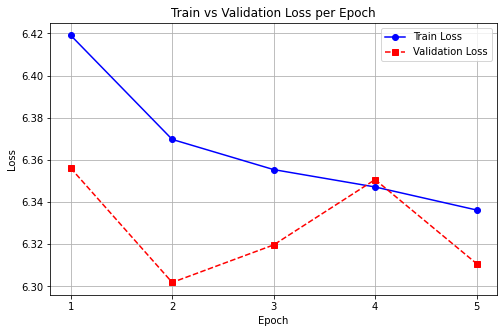

In [12]:
import matplotlib.pyplot as plt

# 에포크 리스트 (x축)
epochs = list(range(1, len(train_last_total_loss_per_epoch) + 1))

# 그래프 그리기
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_last_total_loss_per_epoch, marker='o', linestyle='-', label='Train Loss', color='blue')
plt.plot(epochs, val_last_total_loss_per_epoch, marker='s', linestyle='--', label='Validation Loss', color='red')

# 그래프 제목 및 라벨
plt.title("Train vs Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(epochs)  # X축 눈금 에포크에 맞추기
plt.legend()  # 범례 추가
plt.grid(True)  # 격자 표시

# 그래프 출력
plt.show()

# 추론 모델 만들기

In [47]:
# 학습된 모델 불러오기
model = simplebaseline_model()
model.load_weights('simplebaseline_model-epoch-2-loss-6.3019.h5')

In [48]:
# 학습에 사용했던 keypoint 들을 사용해야 하기 때문에 필요한 변수를 지정
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [49]:
# 모델을 학습할 때 라벨이 되는 좌표를 heatmap으로 바꿨기 때문에 모델이 추론해 내놓은 결과도 heatmap이다.
# 그래서 이 heatmap으로부터 좌표를 추출해야 한다.
# heatmap중에 최대값을 갖는 지점을 찾아내면 된다.
# 아래는 heatmap에서 최대값을 찾는 함수
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [50]:
# 위 함수만으로는 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생한다.
# 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구한다.
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [51]:
# 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [52]:
# 시각화, 그림그리기
# keypoint들과 뼈대 그리기. keypoint들은 관절 역할을 하고 keypoint들을 연결시킨 것이 뼈대.
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

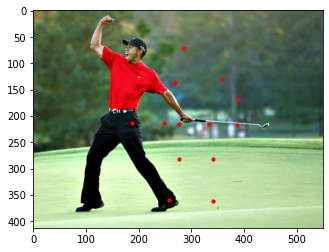

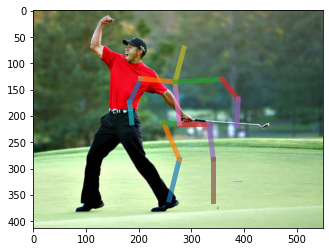

In [53]:
# 스트 이미지를 이용해 모델의 성능 확인
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

In [54]:
# 엥?.....

In [55]:
# 모델 훈련 최적화가 안된듯 하다. Learning Rate 및 에포크를 조절하여 모델 최적화를 추가적으로 진행해야할 것 같다.